# Исследование данных маркетинговой кампании развлекательного приложения Procrastinate Pro+

**Задачи**

1) выявить откуда приходят пользователи и какими устройствами они пользуются,

2) сколько стоит привлечение пользователей из различных рекламных каналов,

3) сколько денег приносит каждый клиент,

4) когда расходы на привлечение клиента окупаются,

5) какие факторы мешают привлечению клиентов.


Структура **visits_info_short.csv** (информация о посещениях сайта):
- User Id — уникальный идентификатор пользователя,
- Region — страна пользователя,
- Device — тип устройства пользователя,
- Channel — идентификатор источника перехода,
- Session Start — дата и время начала сессии,
- Session End — дата и время окончания сессии.

Структура **orders_info_short.csv** (информация о заказах):
- User Id — уникальный идентификатор пользователя,
- Event Dt — дата и время покупки,
- Revenue — сумма заказа.

Структура **costs_info_short.csv** (информация о расходах на рекламу.):
- dt — дата проведения рекламной кампании,
- Channel — идентификатор рекламного источника,
- costs — расходы на эту кампанию.

### ШАГ 1. Загрузка данных и подготовка их к анализу

In [1]:
# загружаем библиотеки для анализа

import pandas as pd
import numpy as np
from datetime import datetime, timedelta
from matplotlib import pyplot as plt

In [2]:
# загрузка данных, визиты, заказы, расходы на рекламу

visits = pd.read_csv('https://code.s3.yandex.net/datasets/visits_info_short.csv') #визиты
orders = pd.read_csv('https://code.s3.yandex.net/datasets/orders_info_short.csv') #заказы
costs = pd.read_csv('https://code.s3.yandex.net/datasets/costs_info_short.csv') #расходы
display(visits.head(5))
print('-'*50)
display(orders.head(5))
print('-'*50)
display(costs.head(5))

,User Id,Region,Device,Channel,Session Start,Session End
0,981449118918,United States,iPhone,organic,2019-05-01 02:36:01,2019-05-01 02:45:01
1,278965908054,United States,iPhone,organic,2019-05-01 04:46:31,2019-05-01 04:47:35
2,590706206550,United States,Mac,organic,2019-05-01 14:09:25,2019-05-01 15:32:08
3,326433527971,United States,Android,TipTop,2019-05-01 00:29:59,2019-05-01 00:54:25
4,349773784594,United States,Mac,organic,2019-05-01 03:33:35,2019-05-01 03:57:40


--------------------------------------------------


,User Id,Event Dt,Revenue
0,188246423999,2019-05-01 23:09:52,4.99
1,174361394180,2019-05-01 12:24:04,4.99
2,529610067795,2019-05-01 11:34:04,4.99
3,319939546352,2019-05-01 15:34:40,4.99
4,366000285810,2019-05-01 13:59:51,4.99


--------------------------------------------------


,dt,Channel,costs
0,2019-05-01,FaceBoom,113.3
1,2019-05-02,FaceBoom,78.1
2,2019-05-03,FaceBoom,85.8
3,2019-05-04,FaceBoom,136.4
4,2019-05-05,FaceBoom,122.1


**1.1 Изучение и предобработка данных**

In [3]:
# преобразуем данные о времени
visits['Session Start'] = pd.to_datetime(visits['Session Start'])
visits['Session End'] = pd.to_datetime(visits['Session End'])
orders['Event Dt'] = pd.to_datetime(orders['Event Dt'])
costs['dt'] = pd.to_datetime(costs['dt']).dt.date 

In [4]:
# в названиях колонок отсутствует змеиный регистр, добавим его и приведем все к строчным буквам
visits.columns = ['user_id', 'region', 'device', 'channel', 'session_start', 'session_end']
orders.columns = ['user_id', 'event_dt', 'revenue']
costs.columns = ['dt', 'channel', 'costs']

In [5]:
# проверим названия столбцов таблиц
print(visits.columns)
print('-'*50)
print(orders.columns)
print('-'*50)
print(costs.columns)

Index(['user_id', 'region', 'device', 'channel', 'session_start',
       'session_end'],
      dtype='object')
--------------------------------------------------
Index(['user_id', 'event_dt', 'revenue'], dtype='object')
--------------------------------------------------
Index(['dt', 'channel', 'costs'], dtype='object')


**1.2 Проверим данные на пропуски и дубликаты**

In [6]:
# подсчёт пропусков visits, orders, costs
print(visits.isna().sum())
print('-'*50)
print(orders.isna().sum())
print('-'*50)
print(costs.isna().sum())

user_id          0
region           0
device           0
channel          0
session_start    0
session_end      0
dtype: int64
--------------------------------------------------
user_id     0
event_dt    0
revenue     0
dtype: int64
--------------------------------------------------
dt         0
channel    0
costs      0
dtype: int64


In [7]:
# проверка на явные дубликаты visits, orders, costs
print(visits.duplicated().sum())
print('-'*50)
print(orders.duplicated().sum())
print('-'*50)
print(costs.duplicated().sum())

0
--------------------------------------------------
0
--------------------------------------------------
0


**1.3 Проведем проверку соответствия типов данных во всех колонках каждого датафрейма сохранённым в них значениям**

In [8]:
orders.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 40212 entries, 0 to 40211
Data columns (total 3 columns):
 #   Column    Non-Null Count  Dtype         
---  ------    --------------  -----         
 0   user_id   40212 non-null  int64         
 1   event_dt  40212 non-null  datetime64[ns]
 2   revenue   40212 non-null  float64       
dtypes: datetime64[ns](1), float64(1), int64(1)
memory usage: 942.6 KB


In [9]:
visits.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 309901 entries, 0 to 309900
Data columns (total 6 columns):
 #   Column         Non-Null Count   Dtype         
---  ------         --------------   -----         
 0   user_id        309901 non-null  int64         
 1   region         309901 non-null  object        
 2   device         309901 non-null  object        
 3   channel        309901 non-null  object        
 4   session_start  309901 non-null  datetime64[ns]
 5   session_end    309901 non-null  datetime64[ns]
dtypes: datetime64[ns](2), int64(1), object(3)
memory usage: 14.2+ MB


In [10]:
costs.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1800 entries, 0 to 1799
Data columns (total 3 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   dt       1800 non-null   object 
 1   channel  1800 non-null   object 
 2   costs    1800 non-null   float64
dtypes: float64(1), object(2)
memory usage: 42.3+ KB


In [11]:
print(costs.head(3))

           dt   channel  costs
0  2019-05-01  FaceBoom  113.3
1  2019-05-02  FaceBoom   78.1
2  2019-05-03  FaceBoom   85.8


**Вывод шаг 1**

Для исследования предоставленны 3 датафрейма с информацией о посещениях сайта, заказах и расходах на рекламу. Перед началом анализа провели предобработку данных и выявили - пропуски и дубликаты в данных отсутствуют. Колонки с датами привели к типу datetime64 кроме столбца dt, его пока оставляем с типом object, остальные типы соответствуют данным и не требуют преобразования. 

### ШАГ 2. Зададим функции для расчёта и анализа LTV, ROI, удержания и конверсии.

Функции для вычисления значений метрик:

- `get_profiles()` — для создания профилей пользователей,
- `get_retention()` — для подсчёта Retention Rate,
- `get_conversion()` — для подсчёта конверсии,
- `get_ltv()` — для подсчёта LTV и ROI.

Функции для построения графиков:

- `filter_data()` — для сглаживания данных,
- `plot_retention()` — для построения графика Retention Rate,
- `plot_conversion()` — для построения графика конверсии,
- `plot_ltv_roi` — для визуализации LTV и ROI.

In [12]:
# функция для создания пользовательских профилей

def get_profiles(sessions, orders, ad_costs):

    # находим параметры первых посещений
    profiles = (
        sessions.sort_values(by=['user_id', 'session_start'])
        .groupby('user_id')
        .agg(
            {
                'session_start': 'first',
                'channel': 'first',
                'device': 'first',
                'region': 'first',
            }
        )
        .rename(columns={'session_start': 'first_ts'})
        .reset_index()
    )

    # для когортного анализа определяем дату первого посещения
    # и первый день месяца, в который это посещение произошло
    profiles['dt'] = profiles['first_ts'].dt.date
    profiles['month'] = profiles['first_ts'].astype('datetime64[M]')

    # добавляем признак платящих пользователей
    profiles['payer'] = profiles['user_id'].isin(orders['user_id'].unique())

    # считаем количество уникальных пользователей
    # с одинаковыми источником и датой привлечения
    new_users = (
        profiles.groupby(['dt', 'channel'])
        .agg({'user_id': 'nunique'})
        .rename(columns={'user_id': 'unique_users'})
        .reset_index()
    )

    # объединяем траты на рекламу и число привлечённых пользователей
    ad_costs = ad_costs.merge(new_users, on=['dt', 'channel'], how='left')

    # делим рекламные расходы на число привлечённых пользователей
    ad_costs['acquisition_cost'] = ad_costs['costs'] / ad_costs['unique_users']

    # добавляем стоимость привлечения в профили
    profiles = profiles.merge(
        ad_costs[['dt', 'channel', 'acquisition_cost']],
        on=['dt', 'channel'],
        how='left',
    )

    # стоимость привлечения органических пользователей равна нулю
    profiles['acquisition_cost'] = profiles['acquisition_cost'].fillna(0)

    return profiles


In [13]:
# функция для расчёта удержания (Retention Rate) -  get_retention()

def get_retention(
    profiles,
    sessions,
    observation_date,
    horizon_days,
    dimensions=[],
    ignore_horizon=False,
):

    # добавляем столбец payer в передаваемый dimensions список
    dimensions = ['payer'] + dimensions

    # исключаем пользователей, не «доживших» до горизонта анализа
    last_suitable_acquisition_date = observation_date
    if not ignore_horizon:
        last_suitable_acquisition_date = observation_date - timedelta(
            days=horizon_days - 1
        )
    result_raw = profiles.query('dt <= @last_suitable_acquisition_date')

    # собираем «сырые» данные для расчёта удержания
    result_raw = result_raw.merge(
        sessions[['user_id', 'session_start']], on='user_id', how='left'
    )
    result_raw['lifetime'] = (
        result_raw['session_start'] - result_raw['first_ts']
    ).dt.days

    # функция для группировки таблицы по желаемым признакам
    def group_by_dimensions(df, dims, horizon_days):
        result = df.pivot_table(
            index=dims, columns='lifetime', values='user_id', aggfunc='nunique'
        )
        cohort_sizes = (
            df.groupby(dims)
            .agg({'user_id': 'nunique'})
            .rename(columns={'user_id': 'cohort_size'})
        )
        result = cohort_sizes.merge(result, on=dims, how='left').fillna(0)
        result = result.div(result['cohort_size'], axis=0)
        result = result[['cohort_size'] + list(range(horizon_days))]
        result['cohort_size'] = cohort_sizes
        return result

    # получаем таблицу удержания
    result_grouped = group_by_dimensions(result_raw, dimensions, horizon_days)

    # получаем таблицу динамики удержания
    result_in_time = group_by_dimensions(
        result_raw, dimensions + ['dt'], horizon_days
    )

    # возвращаем обе таблицы и сырые данные
    return result_raw, result_grouped, result_in_time

In [14]:
# функция для расчёта конверсии - get_conversion()

def get_conversion(
    profiles,
    purchases,
    observation_date,
    horizon_days,
    dimensions=[],
    ignore_horizon=False,
):

    # исключаем пользователей, не «доживших» до горизонта анализа
    last_suitable_acquisition_date = observation_date
    if not ignore_horizon:
        last_suitable_acquisition_date = observation_date - timedelta(
            days=horizon_days - 1
        )
    result_raw = profiles.query('dt <= @last_suitable_acquisition_date')

    # определяем дату и время первой покупки для каждого пользователя
    first_purchases = (
        purchases.sort_values(by=['user_id', 'event_dt'])
        .groupby('user_id')
        .agg({'event_dt': 'first'})
        .reset_index()
    )

    # добавляем данные о покупках в профили
    result_raw = result_raw.merge(
        first_purchases[['user_id', 'event_dt']], on='user_id', how='left'
    )

    # рассчитываем лайфтайм для каждой покупки
    result_raw['lifetime'] = (
        result_raw['event_dt'] - result_raw['first_ts']
    ).dt.days

    # группируем по cohort, если в dimensions ничего нет
    if len(dimensions) == 0:
        result_raw['cohort'] = 'All users' 
        dimensions = dimensions + ['cohort']

    # функция для группировки таблицы по желаемым признакам
    def group_by_dimensions(df, dims, horizon_days):
        result = df.pivot_table(
            index=dims, columns='lifetime', values='user_id', aggfunc='nunique'
        )
        result = result.fillna(0).cumsum(axis = 1)
        cohort_sizes = (
            df.groupby(dims)
            .agg({'user_id': 'nunique'})
            .rename(columns={'user_id': 'cohort_size'})
        )
        result = cohort_sizes.merge(result, on=dims, how='left').fillna(0)
        # делим каждую «ячейку» в строке на размер когорты
        # и получаем conversion rate
        result = result.div(result['cohort_size'], axis=0)
        result = result[['cohort_size'] + list(range(horizon_days))]
        result['cohort_size'] = cohort_sizes
        return result

    # получаем таблицу конверсии
    result_grouped = group_by_dimensions(result_raw, dimensions, horizon_days)

    # для таблицы динамики конверсии убираем 'cohort' из dimensions
    if 'cohort' in dimensions: 
        dimensions = []

    # получаем таблицу динамики конверсии
    result_in_time = group_by_dimensions(
        result_raw, dimensions + ['dt'], horizon_days
    )

    # возвращаем обе таблицы и сырые данные
    return result_raw, result_grouped, result_in_time

In [15]:
# функция для расчёта LTV и ROI - get_ltv()

def get_ltv(
    profiles,
    purchases,
    observation_date,
    horizon_days,
    dimensions=[],
    ignore_horizon=False,
):

    # исключаем пользователей, не «доживших» до горизонта анализа
    last_suitable_acquisition_date = observation_date
    if not ignore_horizon:
        last_suitable_acquisition_date = observation_date - timedelta(
            days=horizon_days - 1
        )
    result_raw = profiles.query('dt <= @last_suitable_acquisition_date')
    # добавляем данные о покупках в профили
    result_raw = result_raw.merge(
        purchases[['user_id', 'event_dt', 'revenue']], on='user_id', how='left'
    )
    # рассчитываем лайфтайм пользователя для каждой покупки
    result_raw['lifetime'] = (
        result_raw['event_dt'] - result_raw['first_ts']
    ).dt.days
    # группируем по cohort, если в dimensions ничего нет
    if len(dimensions) == 0:
        result_raw['cohort'] = 'All users'
        dimensions = dimensions + ['cohort']

    # функция группировки по желаемым признакам
    def group_by_dimensions(df, dims, horizon_days):
        # строим «треугольную» таблицу выручки
        result = df.pivot_table(
            index=dims, columns='lifetime', values='revenue', aggfunc='sum'
        )
        # находим сумму выручки с накоплением
        result = result.fillna(0).cumsum(axis=1)
        # вычисляем размеры когорт
        cohort_sizes = (
            df.groupby(dims)
            .agg({'user_id': 'nunique'})
            .rename(columns={'user_id': 'cohort_size'})
        )
        # объединяем размеры когорт и таблицу выручки
        result = cohort_sizes.merge(result, on=dims, how='left').fillna(0)
        # считаем LTV: делим каждую «ячейку» в строке на размер когорты
        result = result.div(result['cohort_size'], axis=0)
        # исключаем все лайфтаймы, превышающие горизонт анализа
        result = result[['cohort_size'] + list(range(horizon_days))]
        # восстанавливаем размеры когорт
        result['cohort_size'] = cohort_sizes

        # собираем датафрейм с данными пользователей и значениями CAC, 
        # добавляя параметры из dimensions
        cac = df[['user_id', 'acquisition_cost'] + dims].drop_duplicates()

        # считаем средний CAC по параметрам из dimensions
        cac = (
            cac.groupby(dims)
            .agg({'acquisition_cost': 'mean'})
            .rename(columns={'acquisition_cost': 'cac'})
        )

        # считаем ROI: делим LTV на CAC
        roi = result.div(cac['cac'], axis=0)

        # удаляем строки с бесконечным ROI
        roi = roi[~roi['cohort_size'].isin([np.inf])]

        # восстанавливаем размеры когорт в таблице ROI
        roi['cohort_size'] = cohort_sizes

        # добавляем CAC в таблицу ROI
        roi['cac'] = cac['cac']

        # в финальной таблице оставляем размеры когорт, CAC
        # и ROI в лайфтаймы, не превышающие горизонт анализа
        roi = roi[['cohort_size', 'cac'] + list(range(horizon_days))]

        # возвращаем таблицы LTV и ROI
        return result, roi

    # получаем таблицы LTV и ROI
    result_grouped, roi_grouped = group_by_dimensions(
        result_raw, dimensions, horizon_days
    )

    # для таблиц динамики убираем 'cohort' из dimensions
    if 'cohort' in dimensions:
        dimensions = []

    # получаем таблицы динамики LTV и ROI
    result_in_time, roi_in_time = group_by_dimensions(
        result_raw, dimensions + ['dt'], horizon_days
    )

    return (
        result_raw,  # сырые данные
        result_grouped,  # таблица LTV
        result_in_time,  # таблица динамики LTV
        roi_grouped,  # таблица ROI
        roi_in_time,  # таблица динамики ROI
    )

In [16]:
# функция для сглаживания фрейма - filter_data()

def filter_data(df, window):
    # для каждого столбца применяем скользящее среднее
    for column in df.columns.values:
        df[column] = df[column].rolling(window).mean() 
    return df 

In [17]:
# функция для визуализации удержания (Retention Rate) - plot_retention()

def plot_retention(retention, retention_history, horizon, window=7):

    # задаём размер сетки для графиков
    plt.figure(figsize=(15, 10))

    # исключаем размеры когорт и удержание первого дня
    retention = retention.drop(columns=['cohort_size', 0])
    # в таблице динамики оставляем только нужный лайфтайм
    retention_history = retention_history.drop(columns=['cohort_size'])[
        [horizon - 1]
    ]

    # если в индексах таблицы удержания только payer,
    # добавляем второй признак — cohort
    if retention.index.nlevels == 1:
        retention['cohort'] = 'All users'
        retention = retention.reset_index().set_index(['cohort', 'payer'])

    # в таблице графиков — два столбца и две строки, четыре ячейки
    # в первой строим кривые удержания платящих пользователей
    ax1 = plt.subplot(2, 2, 1)
    retention.query('payer == True').droplevel('payer').T.plot(
        grid=True, ax=ax1
    )
    plt.legend()
    plt.xlabel('Лайфтайм')
    plt.title('Удержание платящих пользователей')

    # во второй ячейке строим кривые удержания неплатящих
    # вертикальная ось — от графика из первой ячейки
    ax2 = plt.subplot(2, 2, 2, sharey=ax1)
    retention.query('payer == False').droplevel('payer').T.plot(
        grid=True, ax=ax2
    )
    plt.legend()
    plt.xlabel('Лайфтайм')
    plt.title('Удержание неплатящих пользователей')

    # в третьей ячейке — динамика удержания платящих
    ax3 = plt.subplot(2, 2, 3)
    # получаем названия столбцов для сводной таблицы
    columns = [
        name
        for name in retention_history.index.names
        if name not in ['dt', 'payer']
    ]
    # фильтруем данные и строим график
    filtered_data = retention_history.query('payer == True').pivot_table(
        index='dt', columns=columns, values=horizon - 1, aggfunc='mean'
    )
    filter_data(filtered_data, window).plot(grid=True, ax=ax3)
    plt.xlabel('Дата привлечения')
    plt.title(
        'Динамика удержания платящих пользователей на {}-й день'.format(
            horizon
        )
    )

    # в чётвертой ячейке — динамика удержания неплатящих
    ax4 = plt.subplot(2, 2, 4, sharey=ax3)
    # фильтруем данные и строим график
    filtered_data = retention_history.query('payer == False').pivot_table(
        index='dt', columns=columns, values=horizon - 1, aggfunc='mean'
    )
    filter_data(filtered_data, window).plot(grid=True, ax=ax4)
    plt.xlabel('Дата привлечения')
    plt.title(
        'Динамика удержания неплатящих пользователей на {}-й день'.format(
            horizon
        )
    )
    
    plt.tight_layout()
    plt.show()

In [18]:
# функция для визуализации конверсии - plot_conversion()

def plot_conversion(conversion, conversion_history, horizon, window=7):

    # задаём размер сетки для графиков
    plt.figure(figsize=(15, 5))

    # исключаем размеры когорт
    conversion = conversion.drop(columns=['cohort_size'])
    # в таблице динамики оставляем только нужный лайфтайм
    conversion_history = conversion_history.drop(columns=['cohort_size'])[
        [horizon - 1]
    ]

    # первый график — кривые конверсии
    ax1 = plt.subplot(1, 2, 1)
    conversion.T.plot(grid=True, ax=ax1)
    plt.legend()
    plt.xlabel('Лайфтайм')
    plt.title('Конверсия пользователей')

    # второй график — динамика конверсии
    ax2 = plt.subplot(1, 2, 2, sharey=ax1)
    columns = [
        # столбцами сводной таблицы станут все столбцы индекса, кроме даты
        name for name in conversion_history.index.names if name not in ['dt']
    ]
    filtered_data = conversion_history.pivot_table(
        index='dt', columns=columns, values=horizon - 1, aggfunc='mean'
    )
    filter_data(filtered_data, window).plot(grid=True, ax=ax2)
    plt.xlabel('Дата привлечения')
    plt.title('Динамика конверсии пользователей на {}-й день'.format(horizon))

    plt.tight_layout()
    plt.show()

In [19]:
 # функция для визуализации LTV и ROI - plot_ltv_roi()

def plot_ltv_roi(ltv, ltv_history, roi, roi_history, horizon, window=7):

    # задаём сетку отрисовки графиков
    plt.figure(figsize=(20, 10))

    # из таблицы ltv исключаем размеры когорт
    ltv = ltv.drop(columns=['cohort_size'])
    # в таблице динамики ltv оставляем только нужный лайфтайм
    ltv_history = ltv_history.drop(columns=['cohort_size'])[[horizon - 1]]

    # стоимость привлечения запишем в отдельный фрейм
    cac_history = roi_history[['cac']]

    # из таблицы roi исключаем размеры когорт и cac
    roi = roi.drop(columns=['cohort_size', 'cac'])
    # в таблице динамики roi оставляем только нужный лайфтайм
    roi_history = roi_history.drop(columns=['cohort_size', 'cac'])[
        [horizon - 1]
    ]

    # первый график — кривые ltv
    ax1 = plt.subplot(2, 3, 1)
    ltv.T.plot(grid=True, ax=ax1)
    plt.legend()
    plt.xlabel('Лайфтайм')
    plt.title('LTV')

    # второй график — динамика ltv
    ax2 = plt.subplot(2, 3, 2, sharey=ax1)
    # столбцами сводной таблицы станут все столбцы индекса, кроме даты
    columns = [name for name in ltv_history.index.names if name not in ['dt']]
    filtered_data = ltv_history.pivot_table(
        index='dt', columns=columns, values=horizon - 1, aggfunc='mean'
    )
    filter_data(filtered_data, window).plot(grid=True, ax=ax2)
    plt.xlabel('Дата привлечения')
    plt.title('Динамика LTV пользователей на {}-й день'.format(horizon))

    # третий график — динамика cac
    ax3 = plt.subplot(2, 3, 3, sharey=ax1)
    # столбцами сводной таблицы станут все столбцы индекса, кроме даты
    columns = [name for name in cac_history.index.names if name not in ['dt']]
    filtered_data = cac_history.pivot_table(
        index='dt', columns=columns, values='cac', aggfunc='mean'
    )
    filter_data(filtered_data, window).plot(grid=True, ax=ax3)
    plt.xlabel('Дата привлечения')
    plt.title('Динамика стоимости привлечения пользователей')

    # четвёртый график — кривые roi
    ax4 = plt.subplot(2, 3, 4)
    roi.T.plot(grid=True, ax=ax4)
    plt.axhline(y=1, color='red', linestyle='--', label='Уровень окупаемости')
    plt.legend()
    plt.xlabel('Лайфтайм')
    plt.title('ROI')

    # пятый график — динамика roi
    ax5 = plt.subplot(2, 3, 5, sharey=ax4)
    # столбцами сводной таблицы станут все столбцы индекса, кроме даты
    columns = [name for name in roi_history.index.names if name not in ['dt']]
    filtered_data = roi_history.pivot_table(
        index='dt', columns=columns, values=horizon - 1, aggfunc='mean'
    )
    filter_data(filtered_data, window).plot(grid=True, ax=ax5)
    plt.axhline(y=1, color='red', linestyle='--', label='Уровень окупаемости')
    plt.xlabel('Дата привлечения')
    plt.title('Динамика ROI пользователей на {}-й день'.format(horizon))

    plt.tight_layout()
    plt.show()

**Вывод шаг 2**

Функции для расчета и визуализации метрик заданы, можно приступать к анализу.

### ШАГ 3. Исследовательский анализ данных.

**3.1 Составление профилей пользователей. Определение минимальной и максимальной даты привлечения пользователей.**

In [20]:
# получаем профили пользователей
profiles = get_profiles(visits, orders, costs)
display(profiles.head(5)) 

,user_id,first_ts,channel,device,region,dt,month,payer,acquisition_cost
0,599326,2019-05-07 20:58:57,FaceBoom,Mac,United States,2019-05-07,2019-05-07 20:58:57,True,1.088172
1,4919697,2019-07-09 12:46:07,FaceBoom,iPhone,United States,2019-07-09,2019-07-09 12:46:07,False,1.107237
2,6085896,2019-10-01 09:58:33,organic,iPhone,France,2019-10-01,2019-10-01 09:58:33,False,0.000000
3,22593348,2019-08-22 21:35:48,AdNonSense,PC,Germany,2019-08-22,2019-08-22 21:35:48,False,0.988235
4,31989216,2019-10-02 00:07:44,YRabbit,iPhone,United States,2019-10-02,2019-10-02 00:07:44,False,0.230769


In [21]:
# Определим минимальную и максимальную даты привлечения пользователей

min_date = profiles['first_ts'].min().date()
max_date = profiles['first_ts'].max().date()
print('Минимальная дата привлечения пользователей', min_date)
print('Максимальная дата привлечения пользователей', max_date)

Минимальная дата привлечения пользователей 2019-05-01
Максимальная дата привлечения пользователей 2019-10-27


**Вывод.**
Данные нам предоставлены за период с 1 мая 2019 года по 27 октября 2019 года. Таблица профилей собрана для дальнейшего анализа и содержит данные об - идентификаторе пользователей, дате и времени начала сессий, канале привлечения пользователей, устройстве с которого был осуществлен вход в приложение, стране нахождения устройства, дате и месяце сессии, а также информация о покупках пользователя (False- покупки не было, True - покупка была) и стоимости привлечения пользователя.

**3.2 Выясним, из каких стран пользователи приходят в приложение и на какую страну приходится больше всего платящих пользователей. Строим таблицу, отражающую количество пользователей и долю платящих из каждой страны.**

In [22]:
# На основе датафрейма (profiles) создаем таблицу с группировкой по регионам с указанием количества пользователей (user_id) 
#и количества платящих пользователей (payer). Сортируем от большего к меньшему по количеству пользователей.
# добавляем колонку доля платящих пользователей (ratio_payer_region)

profiles_region = profiles.groupby('region').agg({'user_id': 'nunique', 'payer': 'sum'})\
                  .sort_values(by='user_id', ascending=False)
profiles_region['ratio_payer_region'] = profiles_region['payer'] / profiles_region['user_id'] * 100
profiles_region.sort_values(by='ratio_payer_region', ascending=False)

,user_id,payer,ratio_payer_region
region,,,
United States,100002,6902,6.901862
Germany,14981,616,4.111875
UK,17575,700,3.982930
France,17450,663,3.799427


**Вывод.** 

Пользователи в приложение приходят из 4 стран - США, Великобритания, Франция, Германия. В результате группировки и расчета данных видно, что наибольшее количество пользователей приходит из США, соответственно, платящих пользователей так же больше всего в этой стране и как ожидаемо доля платящих в США выше, чем в других странах. Важно - в остальных трех странах пришедших пользователей примерно одинаково (15 - 17 тыс. чел.), доля платящих между ними так же почти не отличается (3.8 -4.1%). Между США и остальными странами огромный разрыв в количестве привлеченных пользователей, примерно в 6 раз. Доля платящих в США почти 7% против примерно 4% в каждой из остальных стран. На это должны быть причины. Подводя итог, можно сказать, что в привлечении пользователей в Великобритании, Франции и Германии есть куда расти, ориентируясь на более успешный опыт США, возможно стоит применить их методы в остальных регионах.

**3.3 Выясним какими устройствами пользуются клиенты и какие устройства предпочитают платящие пользователи, для этого построим таблицу, отражающую количество пользователей и долю платящих для каждого устройства.**

In [23]:
# На основе датафрейма (profiles) создаем таблицу с группировкой по устройствам (device) с указанием количества пользователей (user_id) 
#и количества платящих пользователей (payer). Сортируем от большего к меньшему по количеству пользователей.
# добавляем колонку доля платящих пользователей (ratio_payer_device)

profiles_device = profiles.groupby('device').agg({'user_id': 'nunique', 'payer': 'sum'})\
                  .sort_values(by='user_id', ascending=False)                
profiles_device['ratio_payer_device'] = profiles_device['payer'] / profiles_device['user_id'] * 100
profiles_device.sort_values(by='ratio_payer_device', ascending=False)

,user_id,payer,ratio_payer_device
device,,,
Mac,30042,1912,6.364423
iPhone,54479,3382,6.207897
Android,35032,2050,5.851793
PC,30455,1537,5.046790


**Вывод**

Пользователи заходят в приложение с iPhone, Android, PC или Mac. Активнее всего пользуются приложением и превращаются в платящих владельцы iPhone. На втором месте, со значительным отставанием в 1,6 раз владельцы Android, и далее примерно с одинаковым количеством привлеченных пользователей PC и Mac. Доли перехода из посетителей в платящих клиентов у владельцев iPhone и Mac примерно аналогичны и составляют 6.2% и 6.4% соответственно. У Android несколько ниже 5.9%. А вот доля платящих пользователей PC самая маленькая, приблизительно 5.1%. 

Сегодня большая часть жителей планеты проводит в смартфонах огромное количество времени, не удивительно, что объемы привлеченых пользователей через iPhone и Android выше чем через Mac и PC соответственно. Однако между iPhone (54479) и Android(35032) разница очень значительная, примерно в 19,5 тыс чел. Такой разрыв может быть вызван разными причинами, наиболее часто встречающиеся - это неудобство регистрации в приложении (в данном случае у владельцев Android) и разная рекламная кампания. Чтоб подтвердить либо исключить эти подозрения, надо сравнить этапы регистрации на этих устройствах, а так же рекламную кампанию, проводимую в исследуемый период. Задача - увеличить число привлеченных пользователей.

Самая высокая доля перехода в платящих пользователей принадлежит Mac при условии самого низкого показателя привлечения клиентов Есть необходимость сосредоточить силы над увеличением количества привлекаемых пользователей через этот девайс. Большее их количество, при сохранении доли перехода в платящих, позволит значительно увеличить прибыль компании.

Изучим показатели пользователей РС и сравним его с МАС. Количество привлеченных пользователей у них одинаковое (около 30 тыс чел), однако есть большая разница в доли платящих. Так для РС она - 5,05%, а вот у Mac - 6,36%. Причиной низкого коэффициента перехода на одном девайсе и высокого на другом с высокой вероятностью может стать техническое неудобство прохождения этапов оплаты. Не исключено, что в какой-то момент произошел сбой в работе, возникает ошибка при проведении платежа и пользователи попросту не имеют возможности оплатить покупку даже если очень того желают. После достижения увеличения доли платящих до необходимого значения, появится причина увеличить и количесво привлекаемых пользователей.


**3.4 Изучим рекламные источники привлечения и определим каналы, из которых пришло больше всего платящих пользователей. Построим таблицу, отражающую количество пользователей и долю платящих для каждого канала привлечения.**

In [24]:
# На основе датафрейма (profiles) создаем таблицу с группировкой по каналам привлечения (channel) с указанием количества пользователей (user_id) 
#и количества платящих пользователей (payer). Сортируем от большего к меньшему по количеству пользователей.
# добавляем колонку доля платящих пользователей (ratio_payer_channel)

profiles_channel = profiles.groupby('channel').agg({'user_id': 'nunique', 'payer': 'sum'})\
                  .sort_values(by='user_id', ascending=False)
profiles_channel['ratio_payer_channel'] = profiles_channel['payer'] / profiles_channel['user_id'] * 100
profiles_channel.sort_values(by='ratio_payer_channel', ascending=False)

,user_id,payer,ratio_payer_channel
channel,,,
FaceBoom,29144,3557,12.204914
AdNonSense,3880,440,11.340206
lambdaMediaAds,2149,225,10.469986
TipTop,19561,1878,9.600736
RocketSuperAds,4448,352,7.913669
WahooNetBanner,8553,453,5.296387
YRabbit,4312,165,3.826531
MediaTornado,4364,156,3.574702
LeapBob,8553,262,3.063253


**Вывод**

Пользователи в приложение приходят из 11 каналов. Удивительно, но факт - наибольшее количество новых клиентов (причем количество пришедших больше чем через любой другой канал привлечения не меньше чем в 2 раза) пришли самостоятельно (organic). Это отличный показатель популярности приложения среди населения. Однако коэффициент перехода в платящих пользователей самый низкий, что дает повод задуматься о проведении работы по увеличению количества перехода их в платящих.

Несомненный лидер среди платных - канал FaceBoom, он показал наивысший результат и по привлечению новых пользователей (29 тыс чел), и по переходу пользователей в платящих (12,2%). Не плохие показатели у канала TipTop - из 20 тыс привлеченных клиентов 9,6% стали платящими. Но оправдали ли вложения в рекламу на этих каналах и какую прибыль компании они принесли? Ведь покупки еще не означают окупаемость затрат.

К сожалению остальные каналы не дают таких радужных результатов. Так OppleCreativeMedia, LeapBob, WahooNetBanner, MediaTornado и YRabbit привлекли гораздо меньшее число пользователей, да и количеством платящих из их числа тоже не могут похвастаться.

Три канала RocketSuperAds, AdNonSense и lambdaMediaAds имея низкое количество привлеченных в приложение (от 2 до 4,5 тыс. чел) показали высокий процент конвертации пользователей в покупатели (8-11,3%). Тем самым они дают почву для изучения и усиленной работы с ними над увеличением количества новых пользователей приложения.

Чтобы выявить причины большого успеха одних каналов и провалы других требуется более глубокий анализ проведения рекламных кампаний с исследованием объема вложений и видов, способов и методов самих рекламных акций.

### ШАГ 4. Маркетинговое исследование.

**4.1 Рассчитаем общую сумму расходов на маркетинг.**

In [25]:
costs_sum = costs['costs'].sum().round(2)
print(f"""Общие расходы на рекламу {costs_sum} руб.""")

Общие расходы на рекламу 105497.3 руб.


**4.2 Выясним, как траты распределены по рекламным источникам, то есть сколько денег потратили на каждый источник.**

In [26]:
# # На основе датафрейма (costs) создаем таблицу с группировкой по рекламным источникам (channel) 
# с указанием суммы, потраченной на данный канал (costs)

costs_chanel_sum = costs.groupby('channel').agg({'costs': 'sum'})\
                  .sort_values(by='costs', ascending=False)
costs_chanel_sum ['ratio'] = costs_chanel_sum ['costs'] / costs_chanel_sum ['costs'].sum() * 100
costs_chanel_sum

,costs,ratio
channel,,
TipTop,54751.30,51.898295
FaceBoom,32445.60,30.754910
WahooNetBanner,5151.00,4.882589
AdNonSense,3911.25,3.707441
OppleCreativeMedia,2151.25,2.039152
RocketSuperAds,1833.00,1.737485
LeapBob,1797.60,1.703930
lambdaMediaAds,1557.60,1.476436
MediaTornado,954.48,0.904744


**Вывод**

Рассмотрим два канала в которые были сделаны максимальные вложения в рекламу - TipTop (около 55 тыс.р) и FaceBoom (около 32 тыс.р). Вложения в них составили более 80% всего бюджета и судя по всему эти каналы считаются самыми популярными. Из исследования выше мы получили максимальную долю перехода в платящих пользователей от рекламной акции на канале FaceBoom. Сейчас видим, что вложения в рекламу через этот канал оказались ниже чем в TipTop, привлекшего меньше пользователей и давшего меньший процент перехода в платящих клиентов. То есть рекламная кампания через FaceBoom оказалась более эффективной. Необходимо выяснить причину меньшей отдачи от рекламы через канал TipTop при вложениях в него 50% всего рекламного бюджета. Для этого потребуется дополнительное исследование.

В рекламную кампанию через каналы с низким привлечением, но большой конвертацией в платящих - RocketSuperAds, AdNonSense и lambdaMediaAds, были вложены небольшие средства. Однако, соотнося размер вложений в рекламу и информацию о достаточно высоком проценте платящих клиентов еще раз подтверждается сделанный ранее вывод, что работе с этими каналами необходимо уделить больше внимания. 

**4.3 Визуализируем динамику изменения расходов во времени (по неделям и месяцам) по каждому источнику.**

In [27]:
# добавим в таблицу costs 3 новых столбца из (dt) - 1 - неделя проведения сессии (week_dt) 
# 2 - месяц проведения сесси (month_dt) и 3 - (date) с датой сессии в формате date.

costs['dt'] = pd.to_datetime(costs['dt'])
costs['week_dt'] = costs['dt'].dt.isocalendar().week
costs['month_dt'] = costs['dt'].astype('datetime64[M]')
costs['date'] = costs['dt'].dt.date
costs.head(10)

,dt,channel,costs,week_dt,month_dt,date
0,2019-05-01,FaceBoom,113.3,18,2019-05-01,2019-05-01
1,2019-05-02,FaceBoom,78.1,18,2019-05-02,2019-05-02
2,2019-05-03,FaceBoom,85.8,18,2019-05-03,2019-05-03
3,2019-05-04,FaceBoom,136.4,18,2019-05-04,2019-05-04
4,2019-05-05,FaceBoom,122.1,18,2019-05-05,2019-05-05
5,2019-05-06,FaceBoom,118.8,19,2019-05-06,2019-05-06
6,2019-05-07,FaceBoom,101.2,19,2019-05-07,2019-05-07
7,2019-05-08,FaceBoom,100.1,19,2019-05-08,2019-05-08
8,2019-05-09,FaceBoom,93.5,19,2019-05-09,2019-05-09
9,2019-05-10,FaceBoom,104.5,19,2019-05-10,2019-05-10


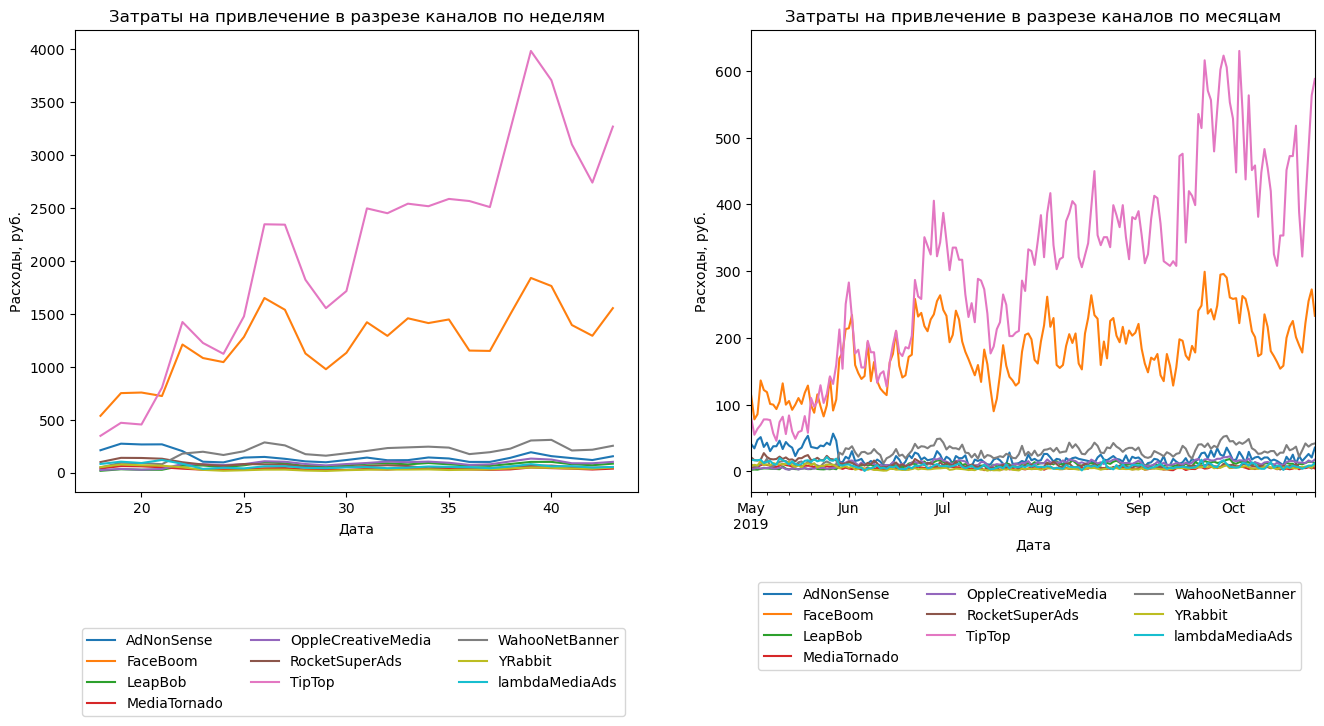

In [28]:
# строим графики динамики затрат по неделям и месяцам на одном.
# ДИНАМИКА ЗАТРАТ по НЕДЕЛЯМ:
fig, ax = plt.subplots(1, 2, figsize=(16, 6)) # размер сетки для графиков

# ДИНАМИКА ЗАТРАТ по НЕДЕЛЯМ:
(costs
 .pivot_table(
    index=costs.week_dt,
    values='costs',
    aggfunc='sum',
    columns='channel'
)
 .plot(ax=ax[0])
)
ax[0].set_title('Затраты на привлечение в разрезе каналов по неделям', loc='center')
ax[0].set_ylabel('Расходы, руб.')
ax[0].set_xlabel('Дата')
ax[0].legend(ncol=3, bbox_to_anchor=(0, -0.5), loc='lower left')



# ДИНАМИКА ЗАТРАТ по месяцам:
(costs
 .pivot_table(
    index=costs.month_dt,
    values='costs',
    aggfunc='sum',
    columns='channel'
)
 .plot(ax=ax[1])
)


ax[1].set_title('Затраты на привлечение в разрезе каналов по месяцам', loc='center')
ax[1].set_ylabel('Расходы, руб.')
ax[1].set_xlabel('Дата')
ax[1].legend(ncol=3, bbox_to_anchor=(0, -0.4), loc='lower left')
plt.show()

**Вывод**

Распределение затрат по неделям и месяцам по всем каналам привлечения кроме FaceBoom и TipTop  на протяжении всего исследуемого периода равномерны, суммы вложений слишком малы и в большинстве своем не превышают 100р в неделю и 500р в месяц.

Основная сумма бюджета на рекламу была вложена в канал TipTop с мая по сентябрь они с каждым месяцем возрастали и при старте в 3000руб в мае к сентябрю достигли 13000 руб в месяц. С октября вложения в рекламу на этом канале стали сокращать. График в разрезе недель дублирует ту же динамику, что и по месяцам. Дополнительно здесь можно проследить в какие именно недели были максимальные затраты, так на 26-27 недели бюджет на рекламу был у величен с 1200 до 2500 рублей, далее снизился до 1500 и начиная с 30 недели снова набрал высоту в 2500 руб. До конца исследуемого периода меньше 2500 руб в неделю не вкладывалось. Самые значительные вложения в рекламу на этом канале компания сделала на 39-40 неделе - около 4000 руб.

Второй канал с большими вложениями в рекламу - FaceBoom. Здесь распределение на всем периоде более равномерное и варируется от 3500 до 6000 руб в месяц. В отличие от канала TipTop максимальное вложение было сделано в августе. После чего ежемесячные траты на рекламу начали постепенно снижаться. Если посмотреть недельные затраты в соответствующий период, видно, что в эти недели траты распределены ориентировочно по 1500 р в неделю (31-34 недели). Максимальные недельные вложения в рекламу компания сделала на 39-40 неделе, так же как и в TipTop.

**4.4 Рассчитаем среднюю стоимость привлечения одного пользователя CAC из каждого источника трафика с использованием профилей пользователей.**

In [29]:
#рассчитываем САС
costs['dt'] = pd.to_datetime(costs['dt']).dt.date 

cac = get_profiles(visits, orders, costs)
display(cac.head(5)) 

,user_id,first_ts,channel,device,region,dt,month,payer,acquisition_cost
0,599326,2019-05-07 20:58:57,FaceBoom,Mac,United States,2019-05-07,2019-05-07 20:58:57,True,1.088172
1,4919697,2019-07-09 12:46:07,FaceBoom,iPhone,United States,2019-07-09,2019-07-09 12:46:07,False,1.107237
2,6085896,2019-10-01 09:58:33,organic,iPhone,France,2019-10-01,2019-10-01 09:58:33,False,0.000000
3,22593348,2019-08-22 21:35:48,AdNonSense,PC,Germany,2019-08-22,2019-08-22 21:35:48,False,0.988235
4,31989216,2019-10-02 00:07:44,YRabbit,iPhone,United States,2019-10-02,2019-10-02 00:07:44,False,0.230769


In [30]:
# исключим из датафрейма данные о пользователях пришедших через канал (organic), 
# так как в их привлечение не вкладывались денежные средства, их нельзя учитывать при расчете САС. 

profiles_no_organic = cac.query('channel != "organic"')
profiles_no_organic['channel'].unique()

array(['FaceBoom', 'AdNonSense', 'YRabbit', 'MediaTornado',
       'RocketSuperAds', 'LeapBob', 'TipTop', 'WahooNetBanner',
       'OppleCreativeMedia', 'lambdaMediaAds'], dtype=object)

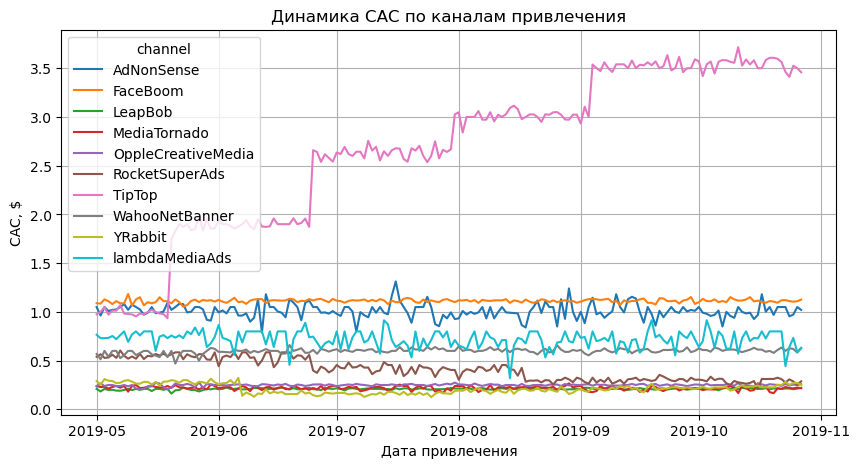

In [31]:
# строим график истории изменения САС по каналам привлечения
profiles_no_organic.pivot_table(
   index='dt', columns='channel', values='acquisition_cost', aggfunc='mean'  
).plot(grid=True, figsize=(10,5))
plt.ylabel('CAC, $')
plt.xlabel('Дата привлечения')
plt.title('Динамика САС по каналам привлечения')
plt.show()

In [32]:
# считаем средний CAC 1 пользователя по каналам привлечения.

channel_cac = profiles_no_organic.groupby('channel').agg(cac=('acquisition_cost', 'mean'))
channel_cac.sort_values(by = 'cac', ascending=False)

,cac
channel,
TipTop,2.799003
FaceBoom,1.113286
AdNonSense,1.008054
lambdaMediaAds,0.724802
WahooNetBanner,0.602245
RocketSuperAds,0.412095
OppleCreativeMedia,0.250000
YRabbit,0.218975
MediaTornado,0.218717


**Вывод.**

Показатель динамики САС по каждому каналу привлечения рассчитан, что мы видим. Все каналы привлечения, кроме TipTop, имеют стабильную ровную динамику с плюс минус не значительным диапозоном. Это означает, что стоимость одного клиента для каждого канала стабильна на протяжении всего исследуемого периода. Другая ситуация с каналом TipTop. Здесь динамика стоимости одного клиента возрастает с каждым месяцем и при старте в мае с 1 доллара к ноябрю начала превышать 3.5.  Пока выводы делать рано. Надо понять какой CAC клиента можно считать хорошим, он должен быть как минимум меньше суммы средней покупки, то есть зависит от среднего чека.Также чтобы понять, хороший ли у компании CAC, нужно сравнить его с показателем LTV — сколько бизнес получает выручки от клиента, пока тот продолжает использовать продукт или услугу компании.


### ШАГ 5. Оцените окупаемость рекламы

Считаем, что на календаре 1 ноября 2019 года, а в бизнес-плане заложено, что пользователи должны окупаться не позднее чем через две недели после привлечения.

**5.1 Анализируем окупаемость рекламы c помощью графиков LTV и ROI, а также графиков динамики LTV, CAC и ROI.**

In [33]:
#определяем момент и горизонт анализа

observation_date = datetime(2019, 11, 1).date()  # момент анализа
horizon_days = 14  # горизонт анализа 

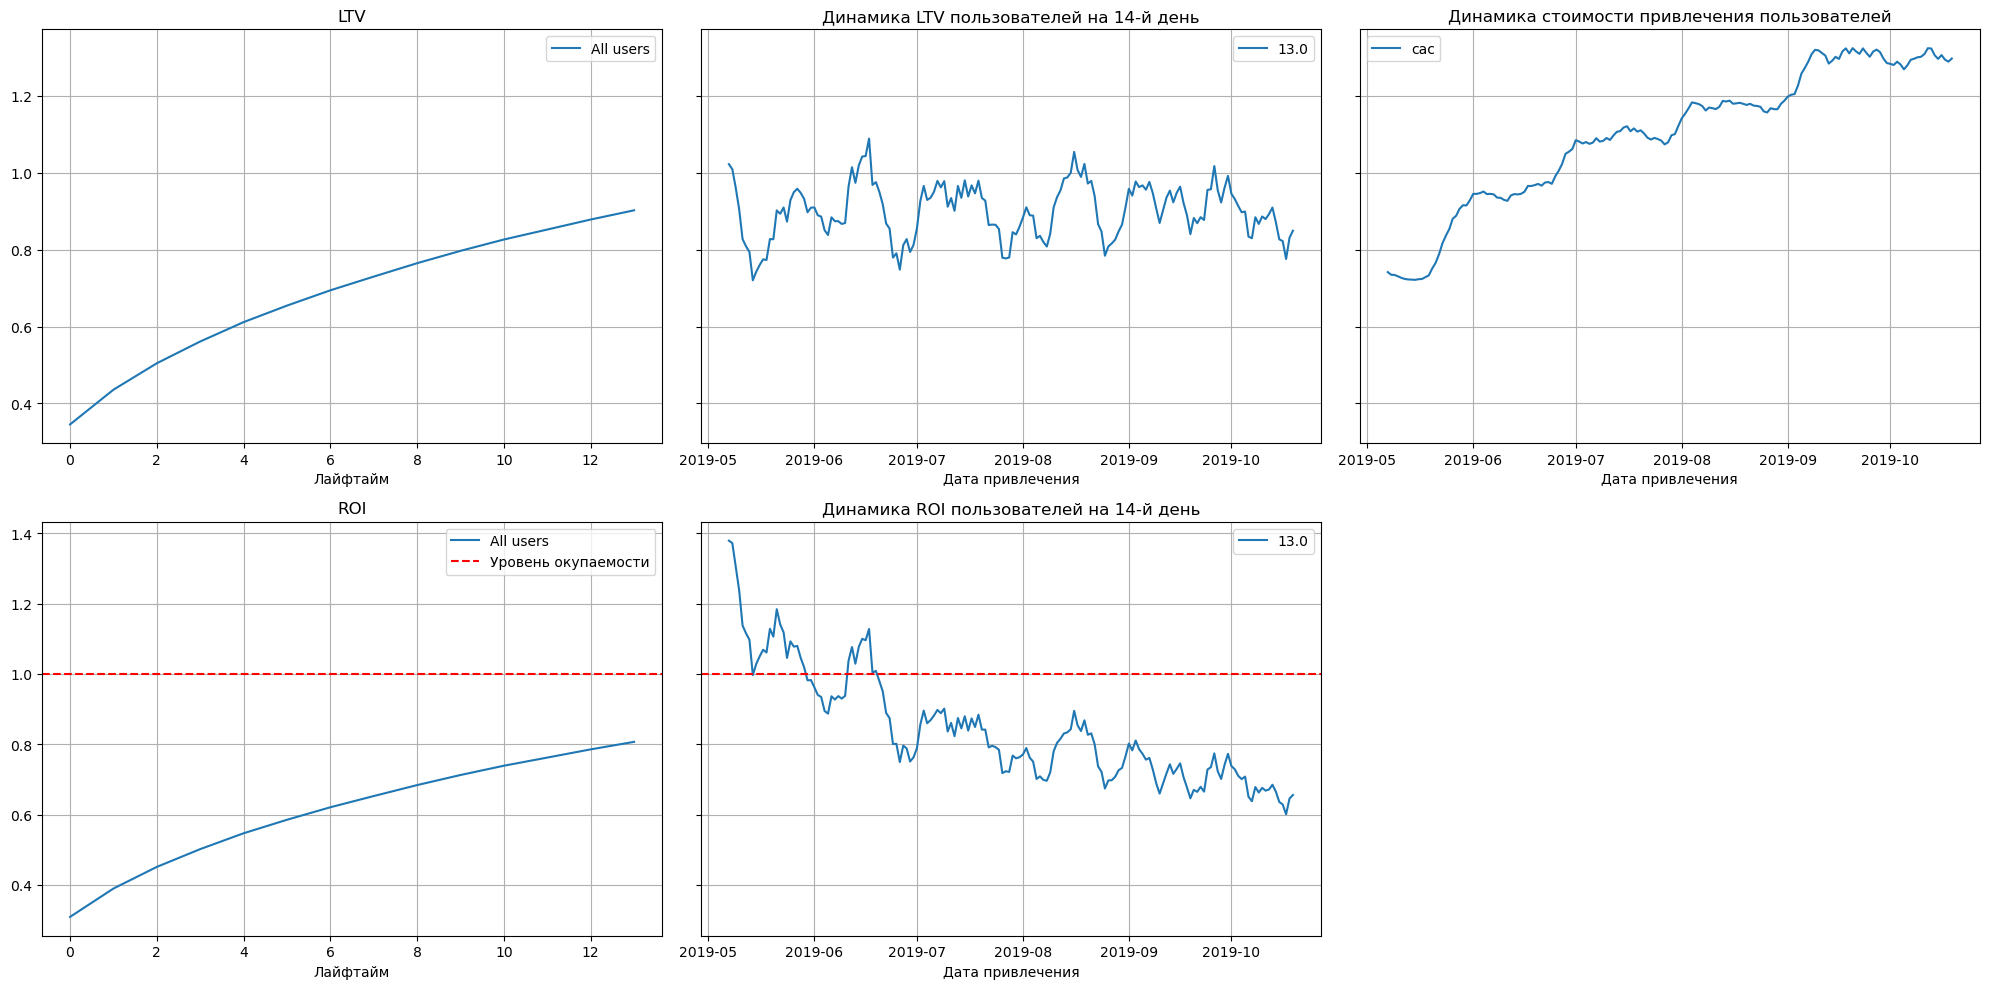

In [34]:
# считаем LTV и ROI

profiles = profiles.query('channel != "organic"')

ltv_raw, ltv_grouped, ltv_history, roi_grouped, roi_history = get_ltv(
    profiles, orders, observation_date, horizon_days
)

# строим графики
plot_ltv_roi(ltv_grouped, ltv_history, roi_grouped, roi_history, horizon_days) 

**По графикам можно сделать такие выводы:**

Реклама не окупается. ROI в конце второй недели только приближается к 1.

Динамика ROI на 14 день со временем снижается. И если в начале исследуемого периода она значительно превышала уровень окупаемости, то к середине июля достигла критического порога и далее постепенно снижалась. К ноябрю окупаемость составляла уже только 80%.

CAC не стабилен. Постоянный рост рекламного бюджета, мог стать одной из причин понесенных убытков.

Динамика показателя LTV достаточно стабилен. Значит, дело не в ухудшении качества пользователей.


**5.2 Проверим конверсию пользователей и динамику её изменения. То же самое сделаем с удержанием пользователей. Изучим их на графиках.**

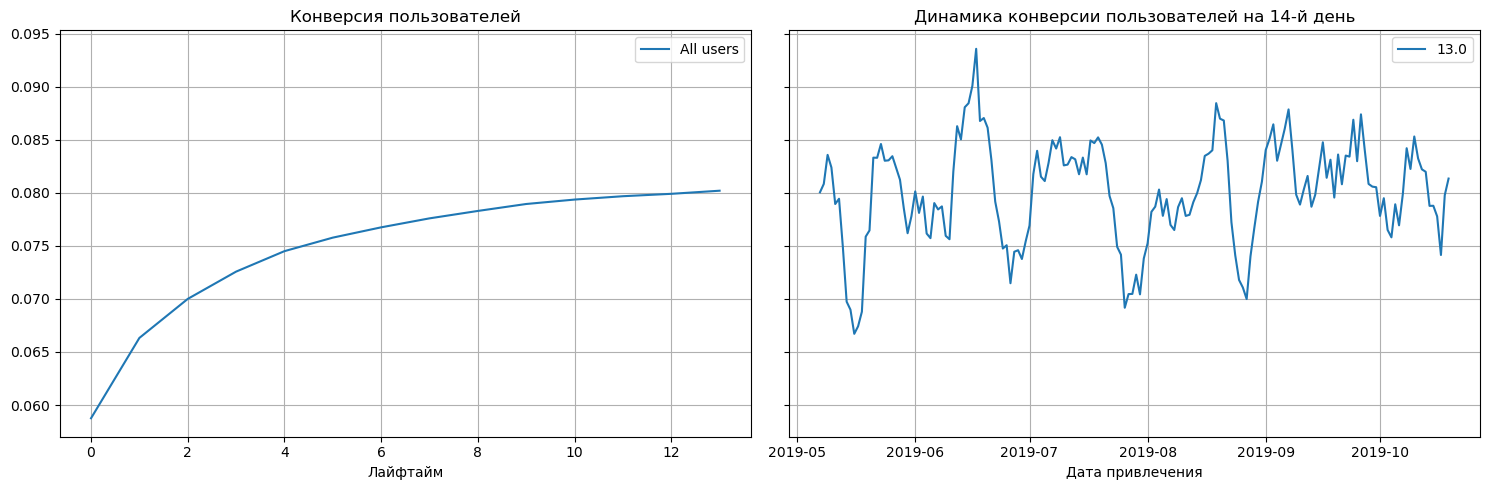

In [35]:
# конверсия пользователей и динамика ее изменения с помощью функции (get_conversion).
conversion_raw, conversion_grouped, conversion_history = get_conversion(
    profiles, orders, observation_date, horizon_days, dimensions=[]
)
plot_conversion(conversion_grouped, conversion_history, horizon_days) 

**Вывод.**

Конверсия пользователей имеет динамику роста, значит расчеты верны. К 14 дню она достигает 5.7%.

По графику динамики конверсии можно сделать вывод, что максимальный успех, постепенным наращиванием количества платящих пользователей с середины мая, был достигнут в середине июня. Конверсия когорт середины июня почти достигла 7%. Далее, на оставшемся промежутке исследования, динамика конверсии более стабильна и варируется в диапазоне 5.5% до 6.5%.



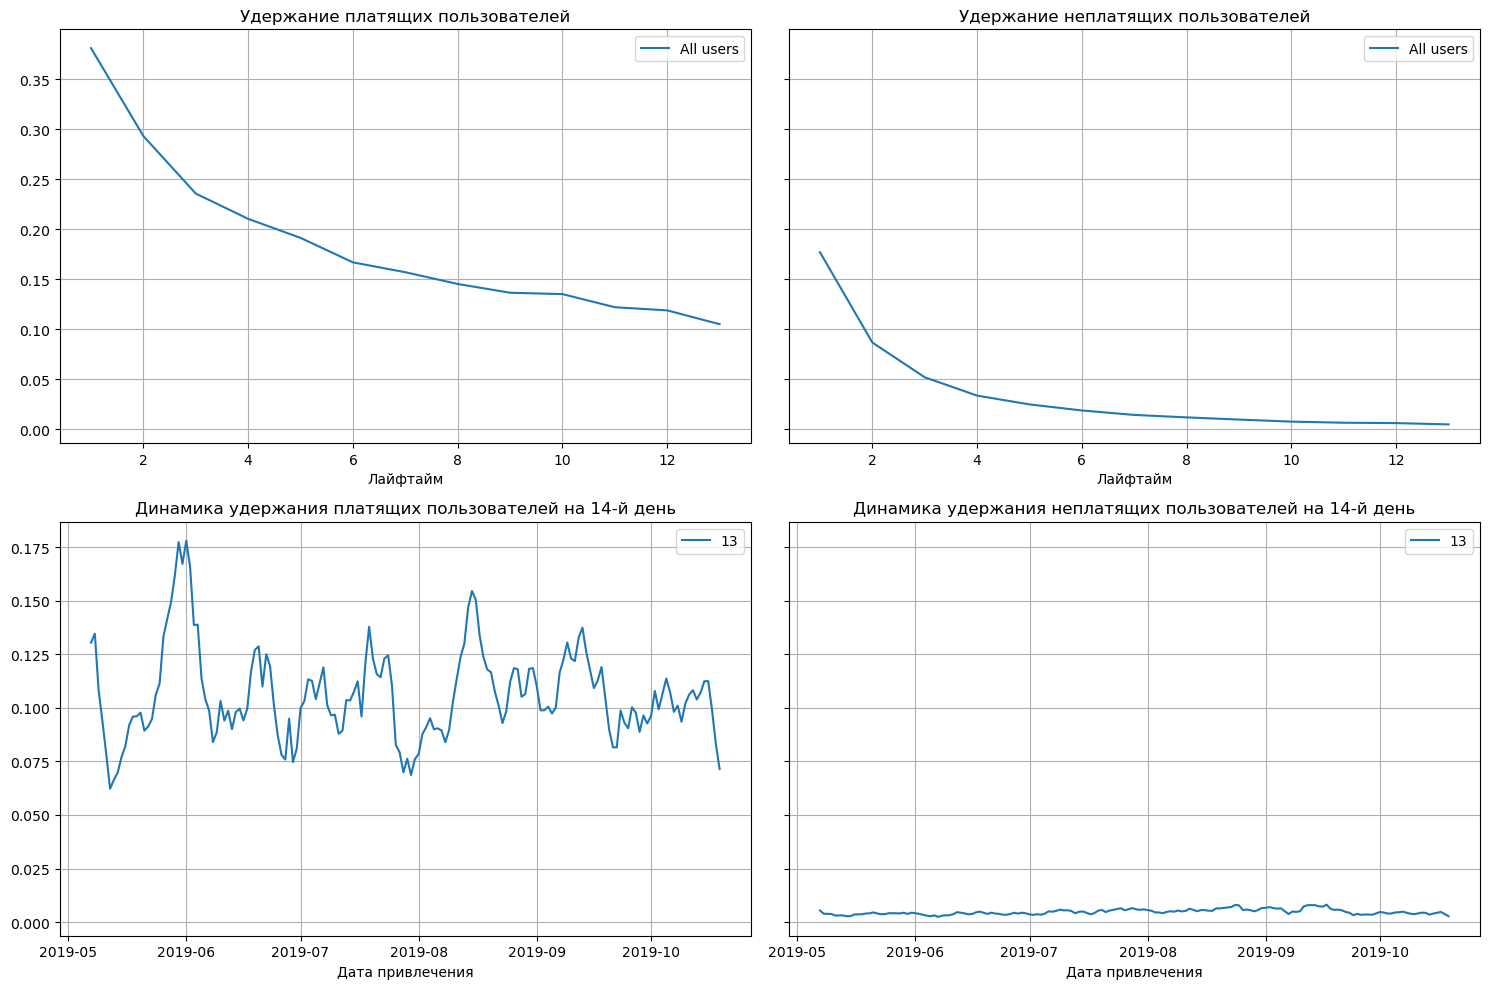

In [36]:
# конверсия удержания пользователей и динамика его изменения.

retention_raw, retention_grouped, retention_history = get_retention(
    profiles, visits, observation_date, horizon_days, dimensions=[]
)

plot_retention(retention_grouped, retention_history, horizon_days) 

**Вывод**

Как и ожидалось кривые удержания пользователей постепенно стремятся к нулю. С одной лишь разницей - процент удержания платящих пользователей на определенные моменты времени всегда выше, чем не платящих. Так, например, на 10 день удержание платящих пользователей составлят 15%, а не платящих уже только 1%.

Динамика удержания не платящих пользователей на 14 день практически равна 0.

Проследим как менялось удержание платящих пользователей от когорты к когорте. Динамика удержания платящих пользователей с течением времени снижается, то есть если в мае показатель держался в диапазоне от 12% до 17.5%, то в ноябре диапазон уже был от 7.5% до 12.5%. 

Так как пользователи в октябре возвращаются в приложение все реже и реже, вероятно, кампания по удержанию пользователей выбрана не верно, требуется выявить проблемные моменты и скорректировать работу в этом направлении. 

**5.3 Анализируем окупаемость рекламы с разбивкой по устройствам. Визуализация с помощью графиков LTV и ROI, а также динамики LTV, CAC и ROI.**

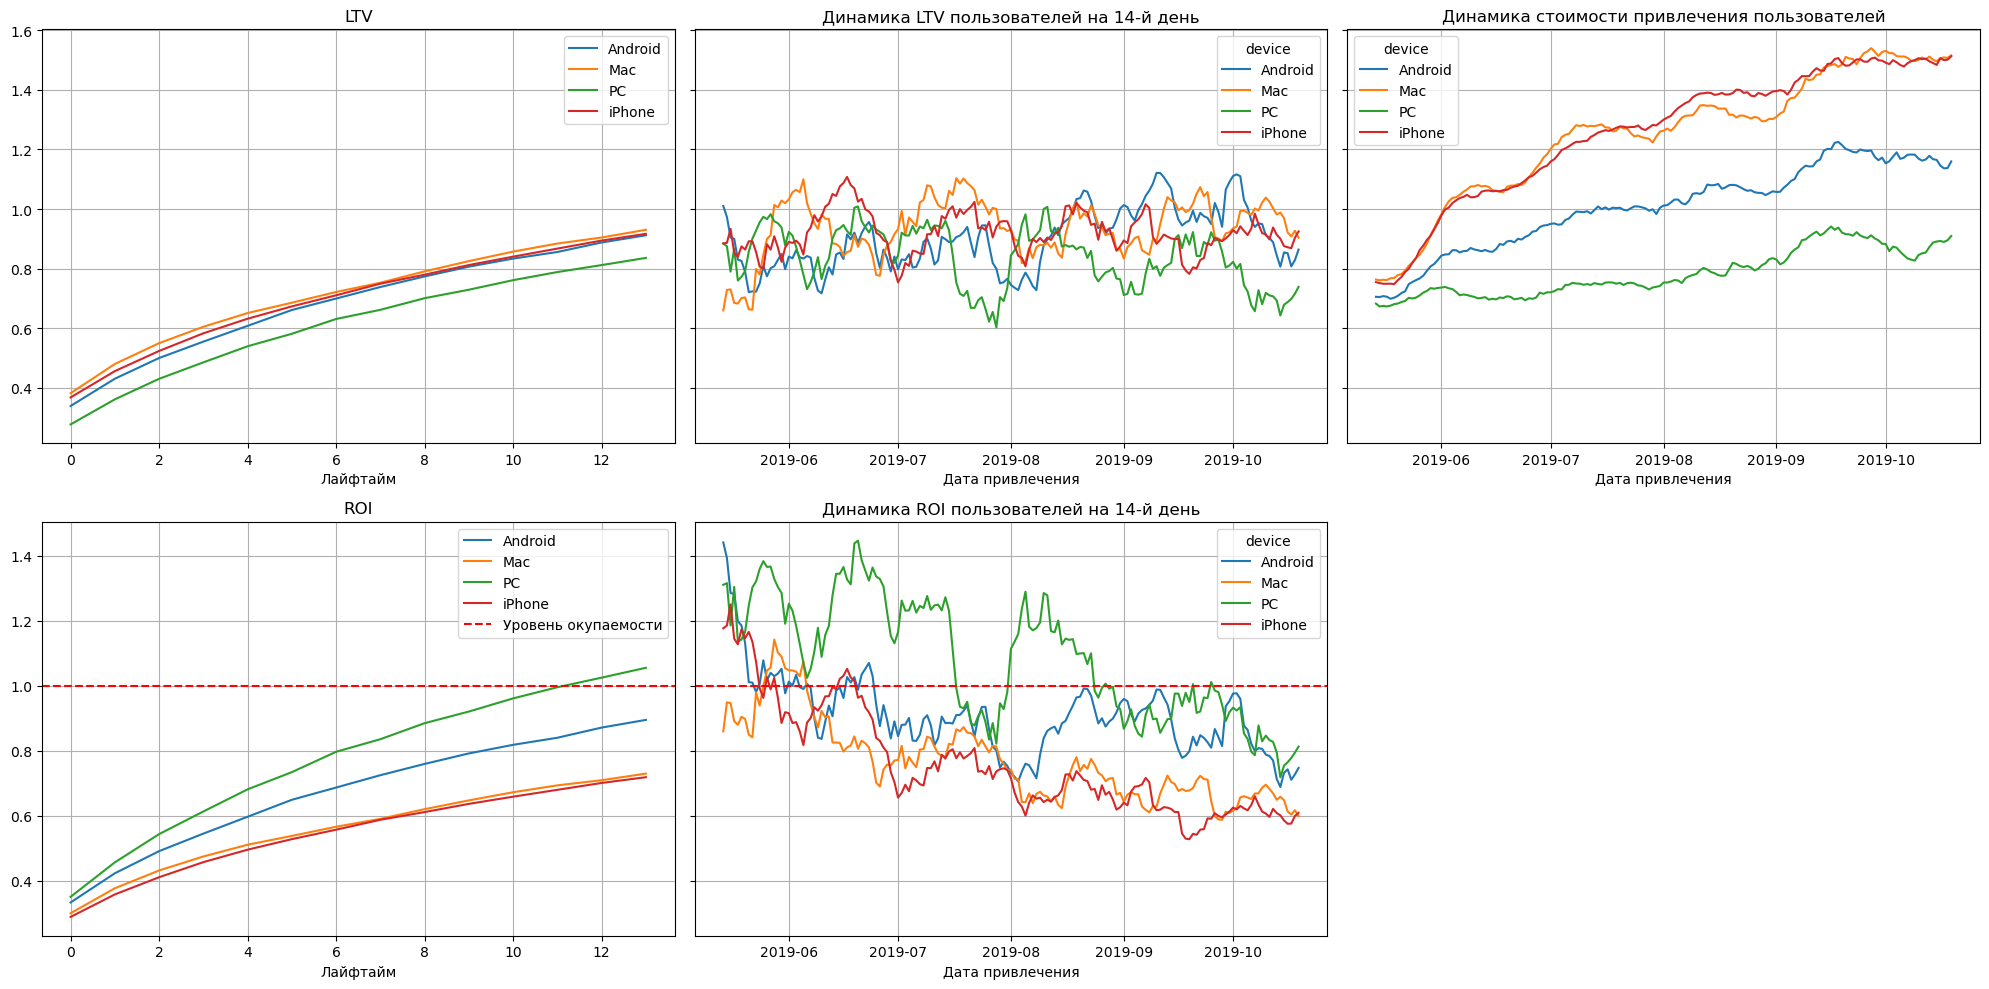

In [37]:
# смотрим окупаемость с разбивкой по устройствам
# передадим параметру dimensions столбец 'device'

dimensions = ['device']

ltv_raw, ltv_grouped, ltv_history, roi_grouped, roi_history = get_ltv(
    profiles, orders, observation_date, horizon_days, dimensions=dimensions
)

plot_ltv_roi(
    ltv_grouped, ltv_history, roi_grouped, roi_history, horizon_days, window=14
) 

**Вывод**

Стоимость привлечения пользователей на всех устройствах постепенно растет, в то время как окупаемость постепенно снижается. Значит увеличение вложений в рекламу не приносит желаемых результатов и не ведет к росту прибыли, а с точность до наоборот ведет к убыткам в бизнесе. Так например в мае владельцы Android окупались больше чем на 200%, а к концу исследуемого периода на 80%. Владельцы РС приблизились к критическому порогу. Но хуже всех обстоят дела с владельцами Мас и IPhone - затраты на рекламу здесь окупаются только на 70%. 

Если стоимость клиента выросла и затраты на маркетинг не окупаются, стоит оптимизировать настройки рекламы или отключить её работу. Чтоб более точно узнать какие рычаги использовать требуется дополнительное исследование метрик.

*Комментарий* 

Узнаем, в чём причина: в низкой конверсии или низком удержании.

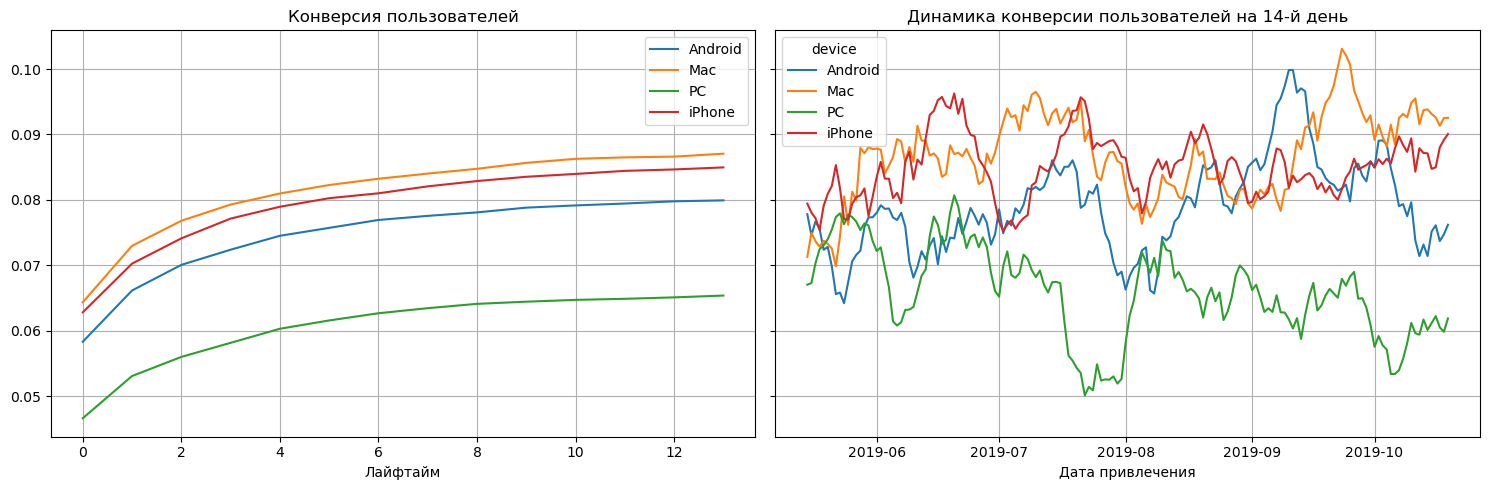

In [38]:
# Посчитаем и визуализируем конверсию, вызвав функции get_conversion() и plot_conversion().
# смотрим конверсию с разбивкой по устройствам

dimensions = ['device']

conversion_raw, conversion_grouped, conversion_history = get_conversion(
    profiles, orders, observation_date, horizon_days, dimensions=dimensions
)

plot_conversion(conversion_grouped, conversion_history, horizon_days, window=15) 

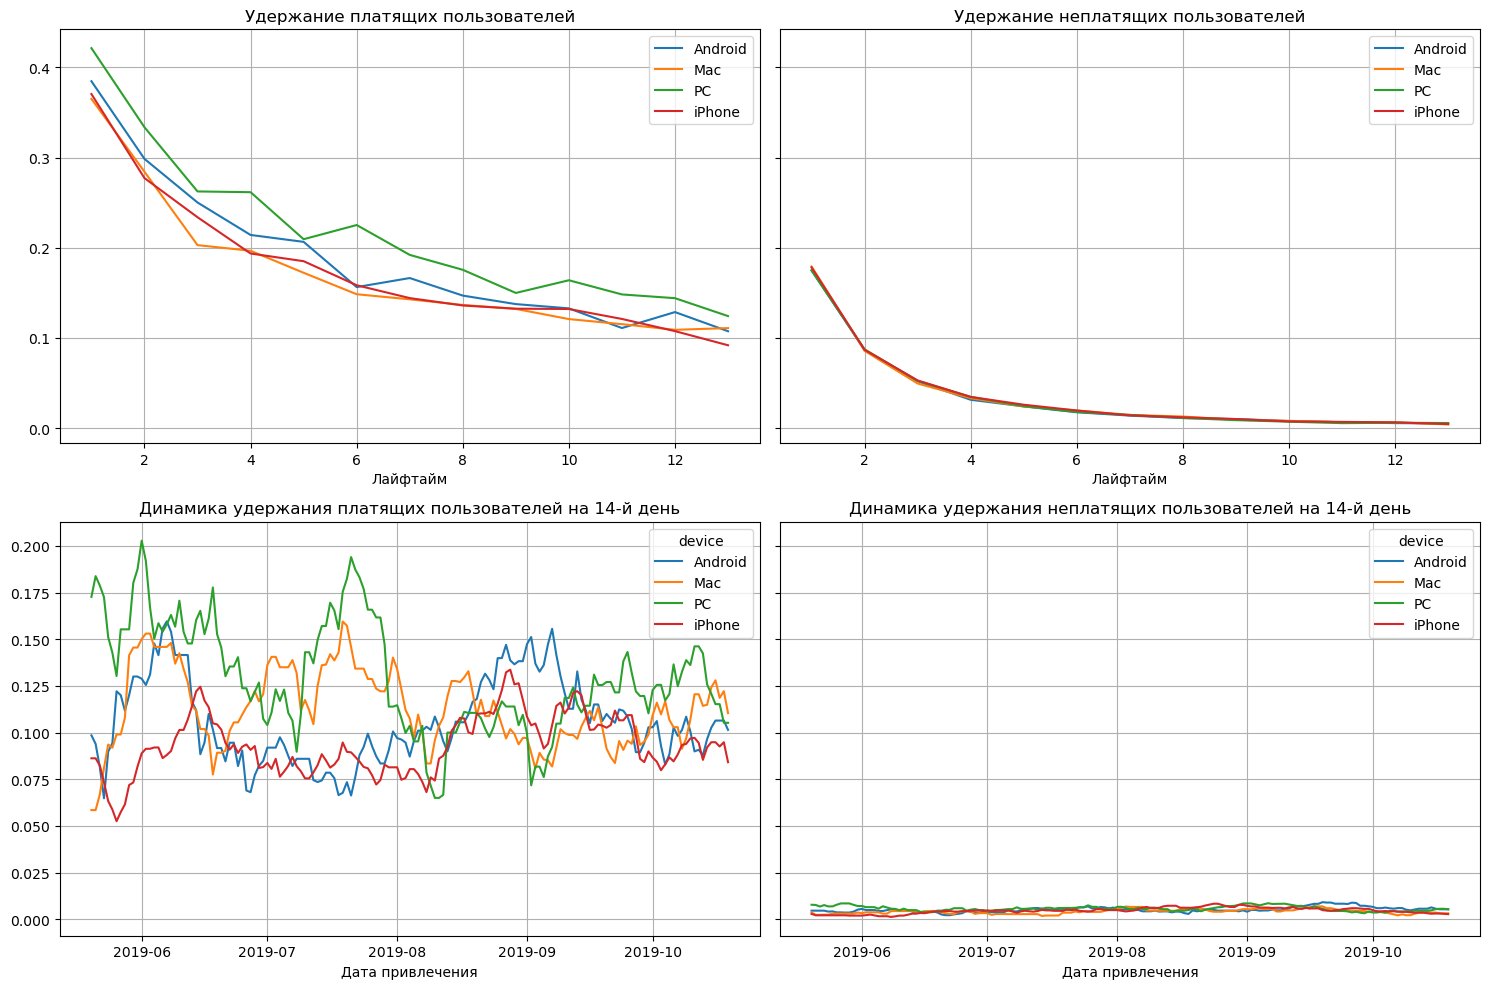

In [39]:
# смотрим удержание с разбивкой по устройствам

retention_raw, retention_grouped, retention_history = get_retention(
    profiles, visits, observation_date, horizon_days, dimensions=dimensions
)

plot_retention(retention_grouped, retention_history, horizon_days, window=20) 

**Вывод**

Судя по графикам пользователи девайсов конвертируются хорошо и постоянно. Удержание пользователей тоже по всем девайсам стабильно хорошее. Значит причина убытков не в используемых устройствах.

**5.4 Анализируем окупаемость рекламы с разбивкой по странам. Визуализация на графиках LTV и ROI, а также динамики LTV, CAC и ROI.**

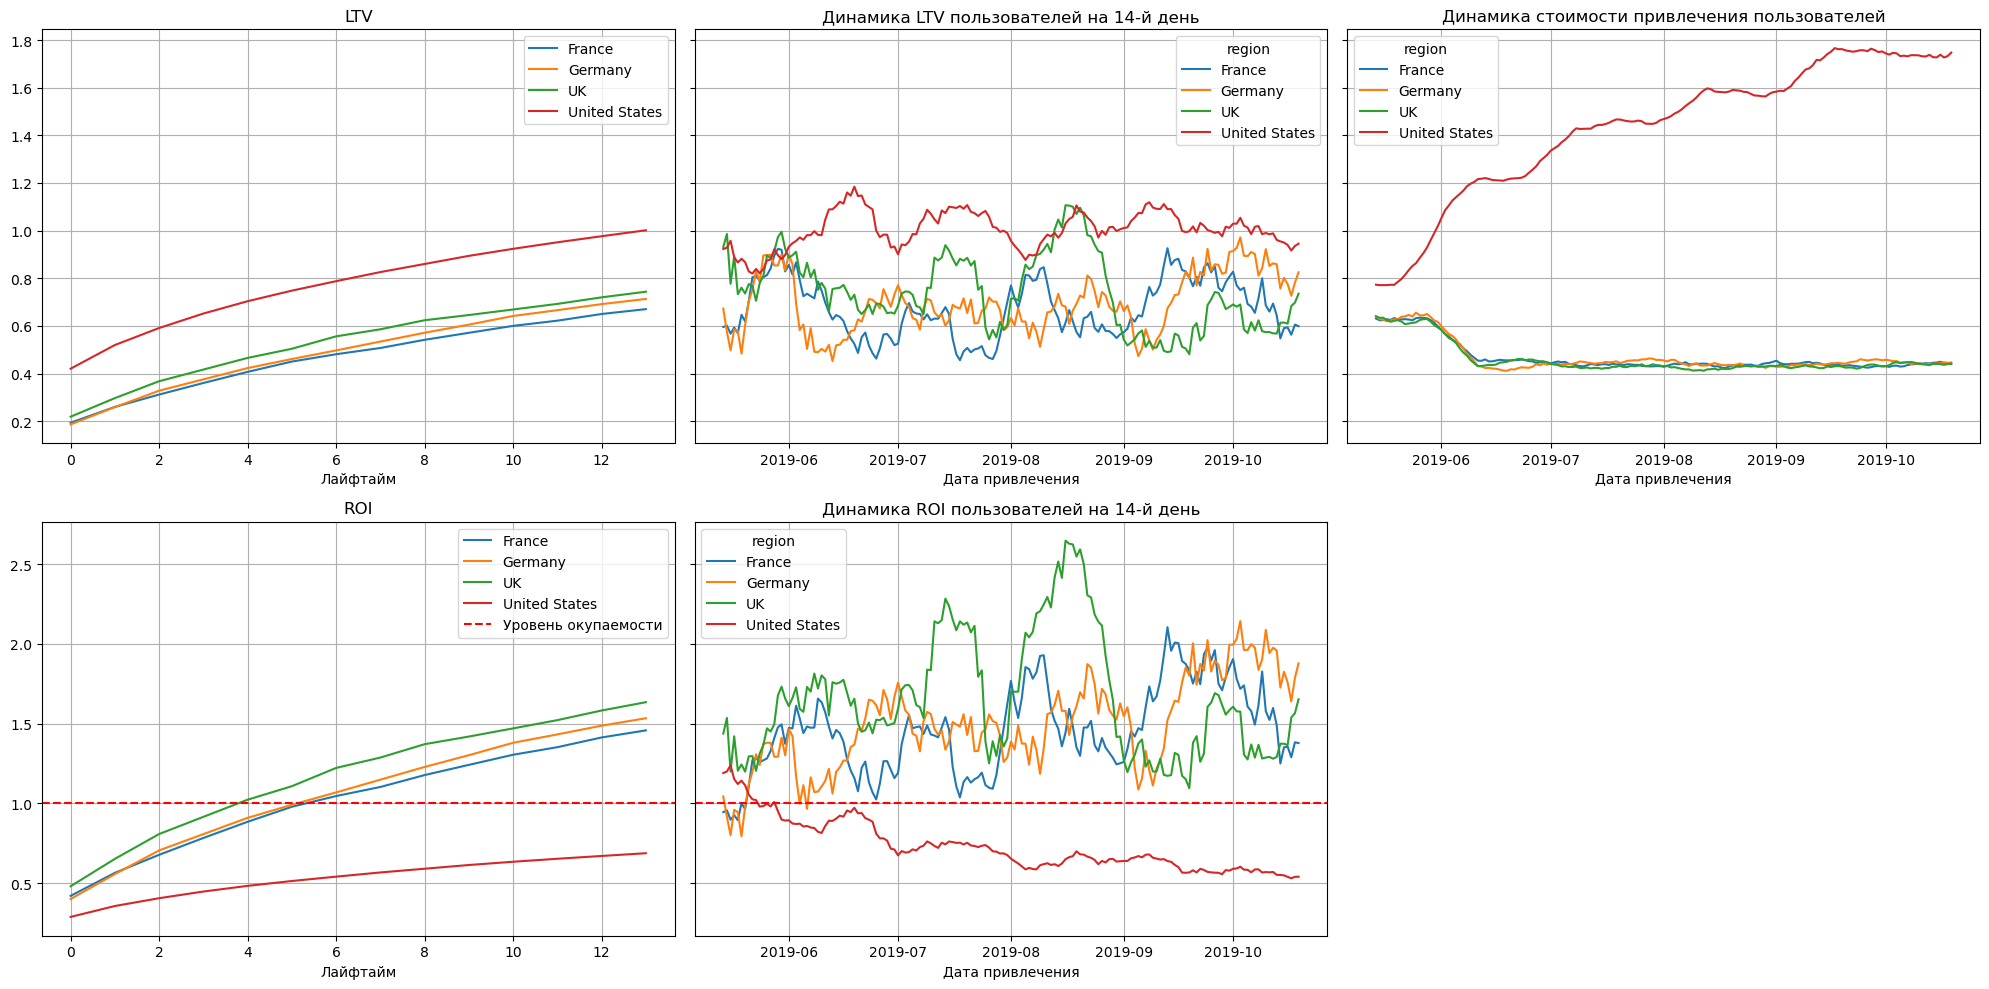

In [40]:
# смотрим окупаемость с разбивкой по странам
# передадим параметру dimensions столбец 'region'

dimensions = ['region']

ltv_raw, ltv_grouped, ltv_history, roi_grouped, roi_history = get_ltv(
    profiles, orders, observation_date, horizon_days, dimensions=dimensions
)

plot_ltv_roi(
    ltv_grouped, ltv_history, roi_grouped, roi_history, horizon_days, window=14
) 

**Вывод**

А вот и основная причина неудач. Высокие вклады в привлечение пользователей из США не оправдвли себя и привели к убыткам. Буквально в течение месяца, то есть уже в июне, реклама перестала окупаться. Имея тенденцию постоянного снижения, к концу исследуемого периода окупаемость пользователей из США составила всего 60%. 

Чего не скажешь о других странах. Их динамика вполне стабильна и не сильно отличается друг от друга. Ни в одной из трех стран (Великобритания, Германия, Франция) не становилась меньше порога в 120%.

Наиболее успешные рекламные вложения были сделанны в Великобритании. В середине июля и августа окупаемость достигала 300%. 

*Комментарий** 

Проверим конверсию и удержание с разбивкой по региону.

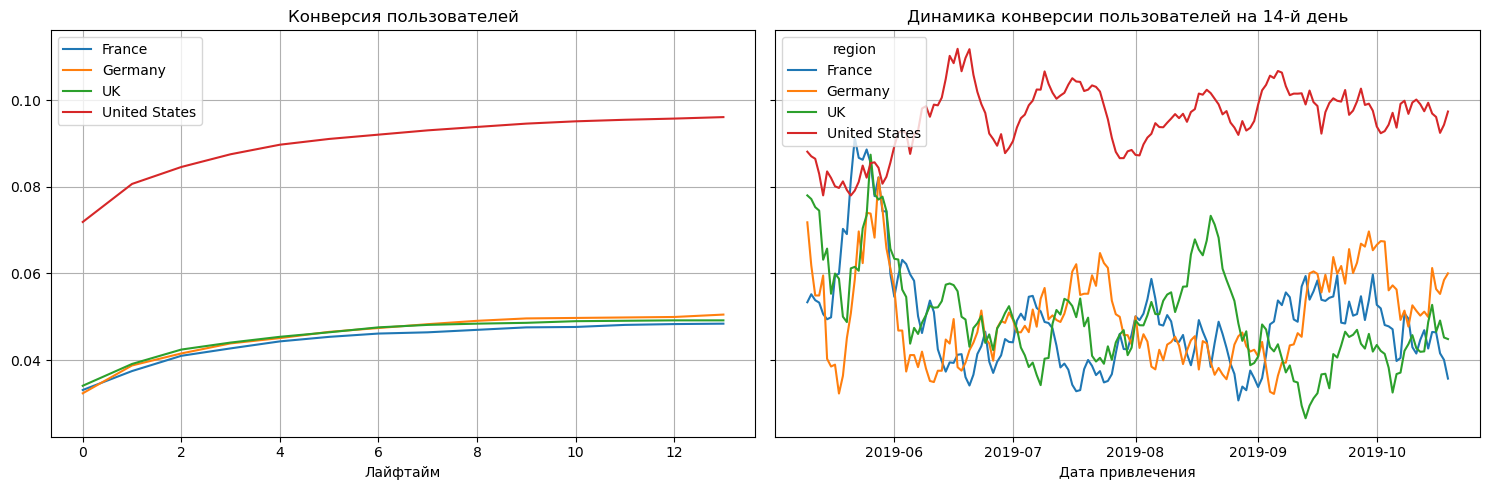

In [41]:
# Посчитаем и визуализируем конверсию, вызвав функции get_conversion() и plot_conversion().
# смотрим конверсию с разбивкой по регионам

dimensions = ['region']

conversion_raw, conversion_grouped, conversion_history = get_conversion(
    profiles, orders, observation_date, horizon_days, dimensions=dimensions
)

plot_conversion(conversion_grouped, conversion_history, horizon_days, window=10) 

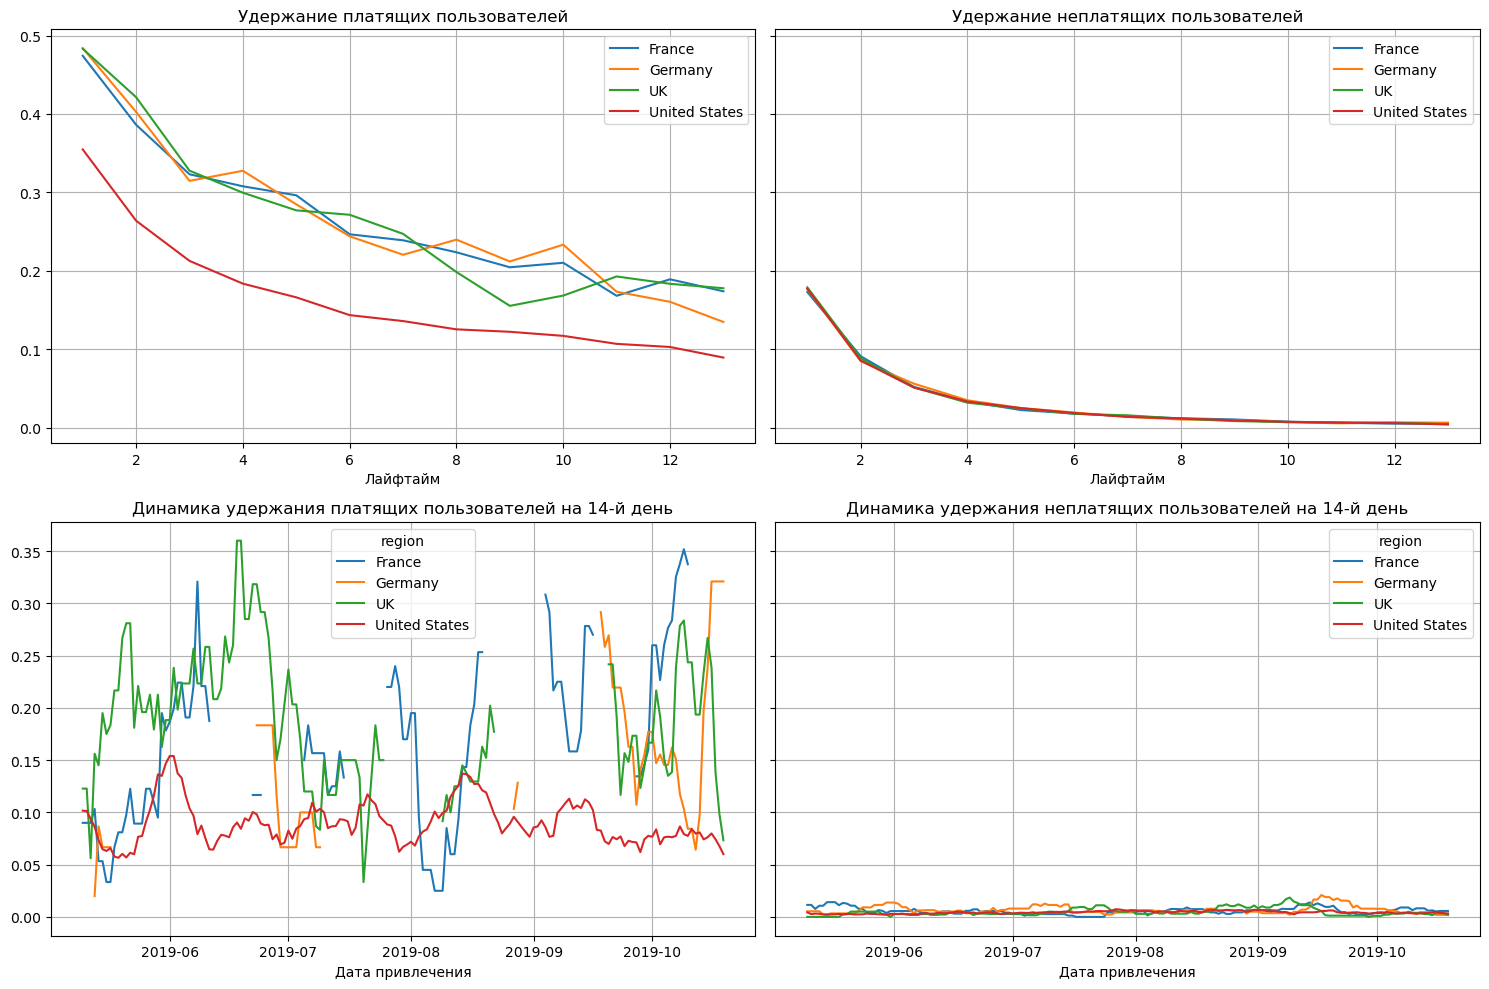

In [42]:
# смотрим удержание с разбивкой по регионам

retention_raw, retention_grouped, retention_history = get_retention(
    profiles, visits, observation_date, horizon_days, dimensions=dimensions
)

plot_retention(retention_grouped, retention_history, horizon_days, window=10) 

**Вывод**

конверсия пользователей из США стабильно высокая, а вот удержание стабильно низкое. Значит высокие вложения в привлечение пользователей, неоправдали ожидания низким удержанием клиентов.

**5.5 Анализируем окупаемость рекламы с разбивкой по рекламным каналам. Визуализация на графиках LTV и ROI, а также динамики LTV, CAC и ROI.**

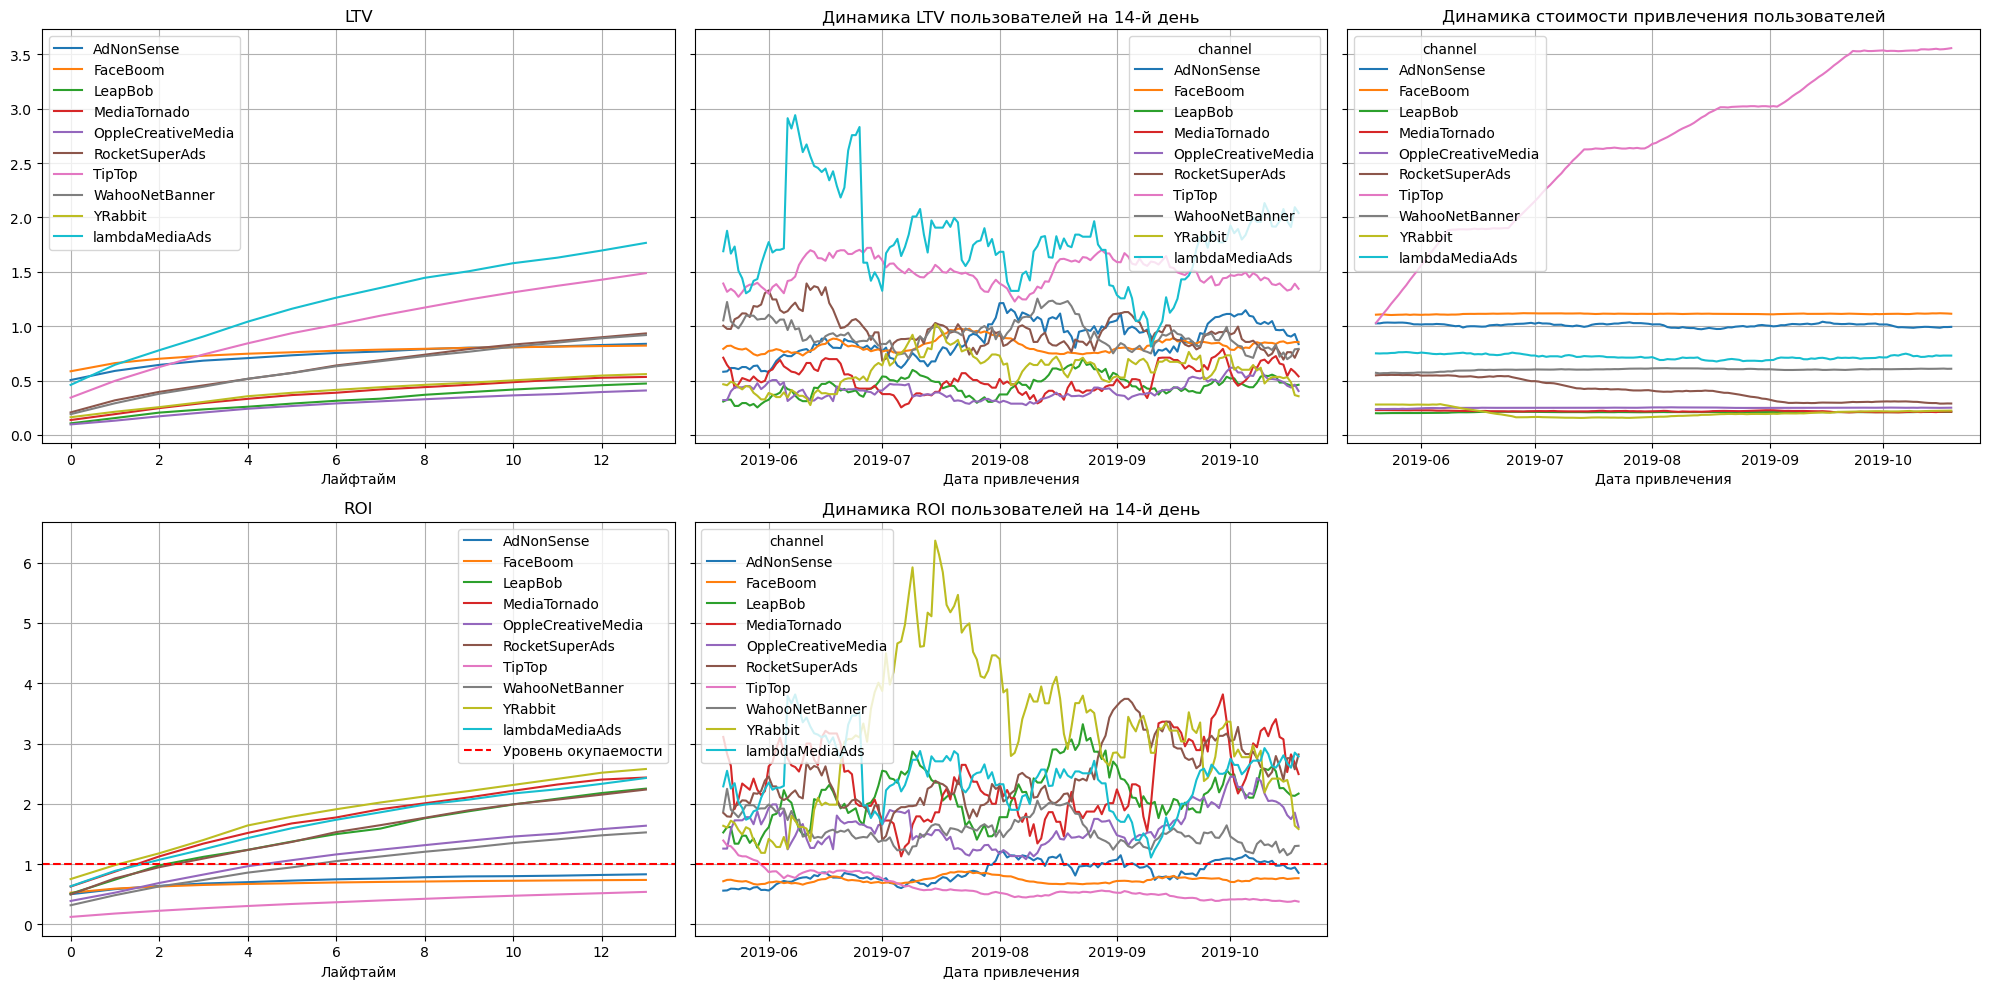

In [43]:
# смотрим окупаемость с разбивкой по источникам привлечения
# передадим параметру dimensions столбец 'channel'

dimensions = ['channel']

ltv_raw, ltv_grouped, ltv_history, roi_grouped, roi_history = get_ltv(
    profiles, orders, observation_date, horizon_days, dimensions=dimensions
)

plot_ltv_roi(
    ltv_grouped, ltv_history, roi_grouped, roi_history, horizon_days, window=20
) 

**Вывод**

Большая часть каналов привлечения окупаются уже на 2 день. Это хорошая динамика. Однако есть три канала, которые не окупаются даже на 14 день. Это 'FaceBoom', 'AdNonSense' и 'TipTop'. Самые успешные вложения были сделанны в канал 'YRabbit'. Наоборт самой ошибочным стала работа с каналом 'TipTop' - на рекламу ежемесячно выделялись самые большие расходы, однако они не окупались. С июня вложения в него стали убыточными и, ежемесячно увеличивая выделяемую сумму на рекламу на этом канале, компания только все больше наращивала убытки.

Раз есть каналы приносящие прибыль, и есть каналы приносящие убытки, значит одна из причин потери финансовой прибыли -  источники привлечения. Имея альтернативные варианты вложения денежных средств в рекламу, стоит задуматься о том, чтобы заменить те, что несут с собой только убытки. Средства регулярно вносимые в них, есть возможность использовать с большей отдачей, вкладывая в каналы которые показали себя как надежные и эффективные партнеры.


*Комментарий*

Посмотрим, что покажет конверсия и удержание с разбивкой по источникам привлечения.

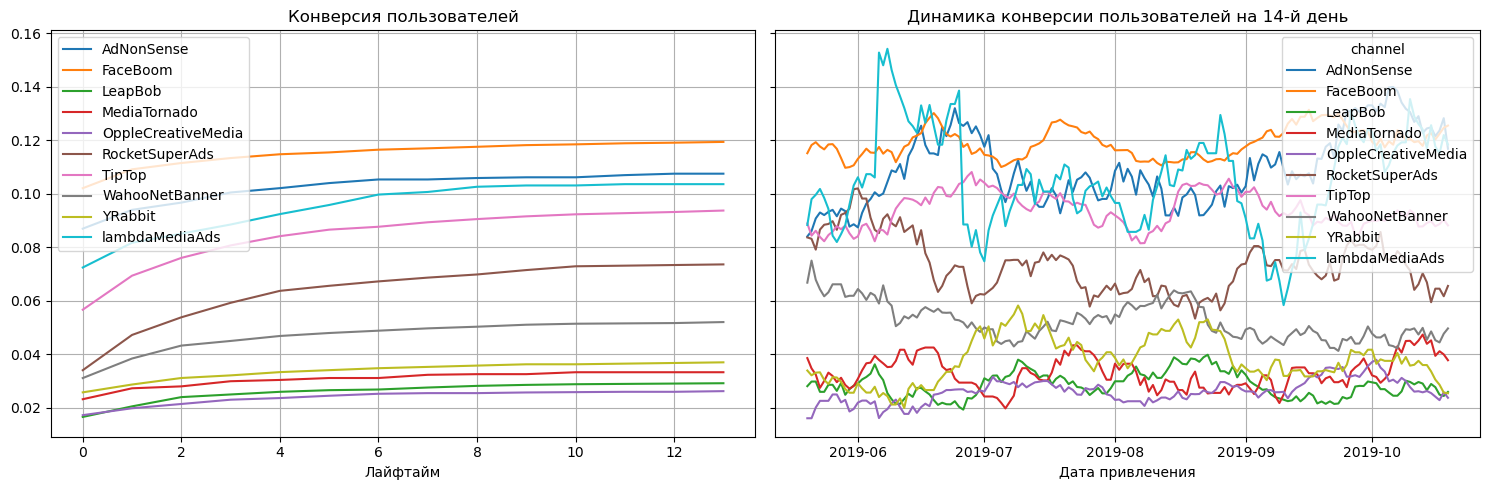

In [44]:
# Посчитаем и визуализируем конверсию, вызвав функции get_conversion() и plot_conversion().
# смотрим конверсию с разбивкой по источникам привлечения

dimensions = ['channel']

conversion_raw, conversion_grouped, conversion_history = get_conversion(
    profiles, orders, observation_date, horizon_days, dimensions=dimensions
)

plot_conversion(conversion_grouped, conversion_history, horizon_days, window=20) 


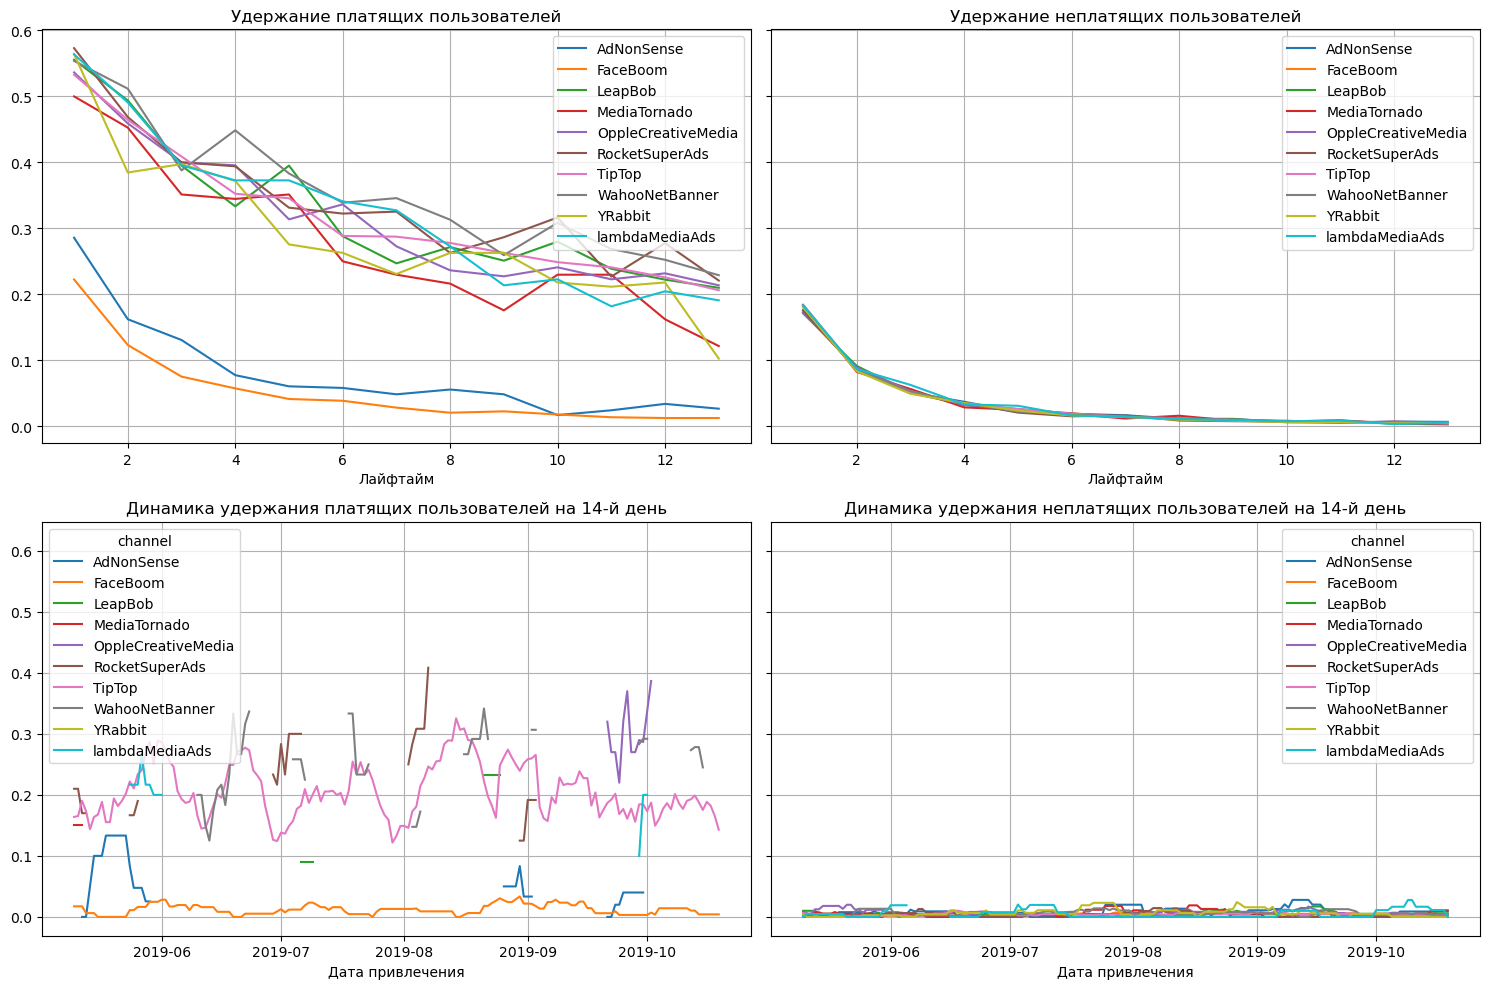

In [45]:
# смотрим удержание с разбивкой по каналам привлечения

retention_raw, retention_grouped, retention_history = get_retention(
    profiles, visits, observation_date, horizon_days, dimensions=dimensions
)

plot_retention(retention_grouped, retention_history, horizon_days, window=10) 

**Вывод**

Из имеющихся данных можно понять, что конверсия у убыточных каналов 'FaceBoom' и 'AdNonSense' очень высокая, а вот удержание  очень низкие. Канал TipTop совершенно не оправдал ожидания фирмы. Имея самые лучшие показатели по привлечению и удержанию пользователей затраты в него были сделанны неоправданно высокие.

**Окупается ли реклама, направленная на привлечение пользователей в целом?** Графики ROI и динамики ROI - показатели рентабельности инвестиций в маркетинг дали нам четкую картину того, что реклама, направленная на привлечение пользователей в целом не окупается.


**Какие устройства, страны и рекламные каналы могут оказывать негативное влияние на окупаемость рекламы?** Основываясь на анализе данных, проведенных выше делаем вывод, что негативное влияние на окупаемость рекламы могут оказывать - страны: США; рекламные каналы - 'FaceBoom' и 'AdNonSense'.  Устройства маловероятно будут являться причиной недостаточной окупаемости рекламы, а очень низкая окупаемость на устройствах Мас и IPhone скорее всего связана с США. Так как большая часть этих девайсов как раз используется жителями этого государства.

**Чем могут быть вызваны проблемы окупаемости?** Причина скорее всего несколько. Одна из главных причин - это отсутствие оптимизации затрат в маркетинге. Вкладывать надо в то, что доказывает свою эффективность. В данном случае, компания несет убытки уже со второго месяца исследования, но на протяжении 5 месяцев не произошло никаких изменений в маркетинговой кампании, что способствовало только росту финансовых потерь с каждым месяцем. Скорее всего в компании не проводили анализ маркетинговых метрик, так как причинно-следственную связь можно было бы выявить гораздо раньше. После чего принять соответствующие меры, направленные на изменение маркетинговой кампании, окупить затраты на рекламу и вывести фирму в прибыль.

**5.7 Проведем дополнительное исследование каналов привлечения в США, чтобы разобраться в столь неуспешной рекламной кампании в этой стране.**

In [46]:
region_channel = profiles.groupby(['region', 'channel'])['channel'].count()

display(region_channel)


region         channel           
France         AdNonSense             1366
               LeapBob                2988
               OppleCreativeMedia     2991
               WahooNetBanner         2971
               lambdaMediaAds          742
Germany        AdNonSense             1219
               LeapBob                2519
               OppleCreativeMedia     2562
               WahooNetBanner         2579
               lambdaMediaAds          649
UK             AdNonSense             1295
               LeapBob                3046
               OppleCreativeMedia     3052
               WahooNetBanner         3003
               lambdaMediaAds          758
United States  FaceBoom              29144
               MediaTornado           4364
               RocketSuperAds         4448
               TipTop                19561
               YRabbit                4312
Name: channel, dtype: int64

**Вывод** Как мы выяснили ранее самые крупные вложения в маркетинговую кампанию на привлечение пользователей были сделаны через каналы FaceBoom и TipTop. Оба этих канала работают только в регионе США.

Канал Tip Top имеет необоснованно завышенный САС. Большие траты на привлечение клиентов не оправдали себя. Считаю, что вложения в данный канал необходимо минимизировать, либо отказаться от работы с ним и рассмотреть остальные и более перспективные каналы в этой стране.

Канал FaceBoom дал самое большое количество привлеченных пользователей и самую высокую долю конвертации их в плательщиков. Это очень достойный показатель успешной работы в этом секторе. При этом динамика удержания клиентов очень низкая. Учитывая то, что канал лидер с большим отрывом от остальных в привлечении и конвертации, отказываться от работы с ним точно не стоит. Проблема на этом канале состоит в низкой способности удержать клиента. Рекомендую тщательно проработать маркетинговую кампанию в этом направлении.

### ШАГ 6.  Выводы и рекомендации.

***ВЫВОДЫ***


Исследование маркетинговых данных компании Procrastinate Pro+ запериод с 1 мая 2019 года по 27 октября 2019 года привело к следующим результатам:

**1** 

Работа маркетинговой кампании ведется в 4 странах - США, Великобритания, Франция, Германия. Наибольшее количество пользователей приложения находятся в США. По доле платящих пользователей так же лидирует эта страна. В то же время, количество привлеченных пользователей в остальных странах почти в 6 раз меньше чем в США. Доля платящих в США почти 7% против примерно 4% в каждой из остальных стран. Необходимо изучить рынок европейских стран и приложить усилия в вопросе роста количества привлекаемых пользователей и их удержания.

**2** 

Сегодня большая часть жителей планеты проводит в смартфонах огромное количество времени, не удивительно, что объемы привлеченых пользователей через iPhone и Android выше чем через Mac и PC соответственно.  Однако между iPhone (54479чел) и Android(35032чел) разница очень значительная, примерно в 19,5 тыс чел. Такой разрыв может быть вызван разными причинами, наиболее часто встречающиеся - это неудобство регистрации в приложении (в данном случае у владельцев Android) и разная рекламная кампания. Основываясь на предыдущем выводе однозначно можно сказать, что с учетом того, что пользователей из США в разы больше, чем пользователей в остальных странах, а наибольшее количество владельцев айфонов проживает в этой стране, то не удивительно, что пользователей этого девайса намного больше. Разница доли конвертации в платящих пользователей между ними не значительна, поэтому вряд ли есть какая-то техническая сложность или неудобство пользования приложением при проведении оплаты. 

   А вот доля перехода в платящих пользователей между владельцами РС и МАС сильно отличается Так для РС она - 5,05%, а вот у Mac - 6,36%. Так как владельцы РС с меньшей охотой становятся покупателями, то следует обратить внимание на качество работы по удержанию пользователей. Причиной низкого коэффициента перехода на одном девайсе и высокого на другом с большой вероятностью может стать техническое неудобство прохождения этапов оплаты.

**3** 

Изучая рекламные источники привлечения выявлен интересный факт - наибольшее количество новых клиентов (причем количество пришедших больше чем через любой другой канал привлечения в 2 раза) пришли самостоятельно (organic). Это отличный показатель популярности приложения среди населения. Однако конвертация в платящих в этой группе пользователей самая низкая, что дает повод задуматься о проведении работы по удержанию клиентов, на привлечение которых не пришлось истратить даже 1 цента.

   Стоит обратить взоры на три канала RocketSuperAds, AdNonSense и lambdaMediaAds. Считаю, что более четкая и структурированная работа с этими каналами по увеличению количества новых пользователей приложения сможет дать компании прибыль. На исследуемый период, имея низкое количество привлеченных в приложение (от 2 до 4,5 тыс. чел), они показали высокий процент конвертации пользователей в покупатели (8-11,3%).

**4** 

Анализ сумм вложенных в рекламу на каждом источнике доказал, что большие вложения не означают большие результаты. Например, два канала в которые были сделаны максимальные вложения - TipTop (около 55 тыс.р) и FaceBoom (около 32 тыс.р). Из исследования выше мы получили максимальную долю перехода в платящих пользователей от рекламной акции на канале FaceBoom. Суммы же вложенные  в рекламу через этот канал оказались значительно ниже чем в TipTop, привлекшего меньше пользователей и давшего меньший процент перехода в платящих клиентов. Таким образом, рекламная кампания через FaceBoom оказалась более эффективной. Необходимо выяснить причину низкой отдачи от рекламы через канал TipTop при вложениях в него 50% всего рекламного бюджета. Для этого потребуется дополнительное исследование.

   В рекламную кампанию через каналы с низким привлечением, но большой конвертацией в платящих - RocketSuperAds, AdNonSense и lambdaMediaAds, были вложены не большие средства. Однако, соотнося размер вложений в рекламу и информацию о достаточно высоком проценте платящих клиентов еще раз подтверждается сделанный ранее вывод, что работе с этими каналами необходимо уделить больше внимания.
   
**5** 

Показатель динамики изменения расходов во времени (по неделям и месяцам) по каждому источнику в очередной раз подтвердил ранее сделанные заключения. Распределение затрат по неделям и месяцам по всем каналам привлечения кроме FaceBoom и TipTop на протяжении всего исследуемого периода равномерны, суммы вложений слишком малы и в большинстве своем не превышают 100р в неделю и 500р в месяц.

  Как изменялось распределение в самых затратных источниках - в канал TipTop с мая по сентябрь вложения быстро возрастали и при старте в 3000руб в мае к сентябрю достигли 13000 руб в месяц. График в разрезе недель дублирует ту же динамику, что и по месяцам. По нему проследим более детальную информацию по платежам, так на 26-27 неделях бюджет на рекламу был у величен с 1200 до 2500 рублей, далее снизился до 1500 и начиная с 30 недели снова набрал высоту в 2500 руб в неделю. До конца исследуемого периода меньше этой суммы уже не опускался. Самые значительные вложения в рекламу на этом канале компания сделала на 39-40 неделе - около 4000 руб.

   Канал FaceBoom. Здесь распределение на всем периоде более равномерное и варируется от 3500 до 6000 руб в месяц. В отличие от канала TipTop максимальное вложение было сделано в августе. После чего ежемесячные траты на рекламу начали постепенно снижаться. Если посмотреть недельные затраты в соответствующий период, видно, что в эти недели траты распределены ориентировочно по 1500 р в неделю (31-34 недели). Максимальные недельные вложения в рекламу компания сделала на 39-40 неделе, так же как и в TipTop.
   
**6** 

Продолжая анализировать каналы привлечения обратим внимание на показатель средней стоимости привлечения одного пользователя из каждого источника. Все каналы, кроме TipTop, имеют стабильную ровную динамику, то есть стоимость одного привлеченного клиента для каждого канала стабильна на протяжении всего исследуемого периода. Другая ситуация с каналом TipTop. Здесь динамика стоимости одного клиента возрастает с каждым месяцем и при старте в мае с 1 доллара к ноябрю начала превышать 3.5 доллара. Чтобы понять рентабельность вложений необходимо выяснить какой CAC клиента можно считать хорошим, он должен быть как минимум меньше суммы среднего чека.Также необходимо сравнить его с показателем LTV и выявить, сколько бизнес получает выручки от клиента, пока тот продолжает использовать продукт или услугу компании.

**7** 

Проводя анализ окупаемости рекламы с помощью построения графиков было сделано следующее заключение - реклама в целом не окупается. При условии, что горизонт анализа взят равным 14 дней, к концу второй недели реклама даже не окупается, не говоря уже о прибыли.

Прошу обратить внимание, что динамика окупаемости в первый месяц исследования имела не плохие результаты со знаком +, компания имела прибыль от проведенной рекламной кампании, однако к середине июля достигла критического порога и далее постепенно только снижалась. К ноябрю окупаемость составляла уже только 80%.

График CAC показал его не стабильность. Постоянный рост рекламного бюджета, мог стать одной из причин понесенных убытков.

Динамика показателя LTV достаточно стабильна. Значит, дело не в ухудшении качества пользователей.

**8** 

Изучая конверсию пользователей в покупатели выявили - она имеет динамику роста. К 14 дню достигает 5.7%.

По графику динамики конверсии видно, что максимальный успех был получен от когорт, привлеченных в середине июня. Их конверсия почти достигла 7%. Далее, на оставшемся промежутке исследования, динамика конверсии более стабильна и варируется в диапазоне 5.5% до 6.5%. Значит причина убыточности скорее всего не связана с конвертацией клиентов в платящих.

Что же с удержанием пользователей? Как и должно быть кривые удержания пользователей постепенно стремятся к нулю. С одной лишь разницей - процент удержания платящих пользователей на определенные моменты времени всегда выше, чем не платящих. Так, например, на 10 день удержание платящих пользователей составлят 15%, а не платящих уже только 1%.
От когорты к когорте динамика удержания платящих пользователей с течением времени снижается, то есть если в мае показатель держался в диапазоне от 12% до 17.5%, то в ноябре диапазон уже был от 7.5% до 12.5%. Так как пользователи в октябре возвращаются в приложение все реже и реже, вероятно, кампания по удержанию пользователей выбрана не верно, требуется выявить проблемные моменты и скорректировать работу в этом направлении.

**9**

Проверяя зависимость окупаемости рекламы от используемого девайса, получили следующие результаты: 

Стоимость привлечения пользователей на всех устройствах постепенно растет, в то время как окупаемость постепенно снижается. Значит увеличение вложений в рекламу не приносит желаемых результатов и не ведет к росту прибыли, а с точность до наоборот ведет к убыткам в бизнесе. Так например в мае владельцы Android окупались больше чем на 200%, а к концу исследуемого периода на 80%. Ни одно из устройств к концу периода не окупается, хотя РС до середины июля находилось в плюсе, и от владельцев этих устройств компания получала прибыль. Но хуже всех обстоят дела с владельцами Мас и IPhone - затраты на рекламу здесь окупаются только на 70%. Так как все устройства со стабильно отрицательной позицией, то причина неудач точно не связана с ними. Дабы убедиться в сделанном выводе провели дополнительное исследование конверсии и удержания пользователей различных девайсов. Конверсия стабильно хорошая, удержание тоже. Вывод подтвержден.

**10**

Анализ окупаемости рекламы с разбивкой по странам выявил основную причину неудач. Высокие вклады в привлечение пользователей из США не оправдвли себя и привели к убыткам. Буквально в течение месяца, то есть уже в июне, реклама перестала окупаться. Имея тенденцию постоянного снижения, к концу исследуемого периода окупаемость пользователей из США составила всего 60%. В остальных странах динамика вполне стабильна и не сильно отличается друг от друга. В Великобритании, Германии и Франции окупаемость не становилась меньше порога в 120%. Наибольшую отдачу компания получила от пользователей из Великобритании. В середине июля и августа окупаемость достигала 300%.

Для более точного выявления причины неудачных вложений в США проверили конверсию и удержание. Конверсия пользователей из США стабильно высокая, а вот удержание стабильно низкое. Значит высокие вложения в привлечение пользователей, неоправдали ожидания низким удержанием клиентов.

**11**

Анализ окупаемости рекламы с разбивкой по рекламным каналам пролил свет на проблемы в рекламной кампании. Большая часть каналов привлечения окупаются уже на 2 день. Динамика хорошая. Однако есть три канала, которые не окупаются даже на 14 день. Это 'FaceBoom', 'AdNonSense' и 'TipTop'. Самые успешные вложения были сделанны в канал 'YRabbit'. Наоборт самой ошибочной стала работа с каналом 'TipTop' - на рекламу ежемесячно выделялись достаточно высокие расходы, однако они не окупались. С июня вложения в него стали убыточными и, ежемесячно увеличивая выделяемую сумму на рекламу на этом канале, компания только все больше наращивала убытки.

Раз есть каналы приносящие прибыль, и есть каналы приносящие убытки, значит одна из причин потери финансовой прибыли - источники привлечения. Имея альтернативные варианты вложения денежных средств в рекламу, стоит задуматься о том, чтобы заменить те, что несут с собой только убытки. В руках компании существует реальная возможность, использовать средства, регулярно вносимые в убыточные каналы, с большей отдачей. Разумней вкладывать в каналы которые показали себя как надежные и эффективные партнеры. Проведя проверку конверсии и удержания с разбивкой по источникам привлечения увидели следующее: конверсия у убыточных каналов 'FaceBoom' и 'AdNonSense' очень высокая, а вот удержание очень низкие. Отдельно выделим канал 'TipTop' - имея хорошую конверсию и удержание он дает худшую окупаемость. В данном канале делались неоправданно высокие затраты на рекламу.


**Резюмируем**

**Причины неэффективности привлечения пользователей.**

Основная причина это отсутствие в компании промежуточного маркетингового анализа, который на ранних стадиях позволяет выявить неверные направления в рекламной кампании и позволяет отрегулировать работу. Фирма ошибочно сделала ставки на жителей США и канал привлечения TipTop. Длительное время увеличивала расходы в этих направлениях, тем самым наращивая свои убытки.

**Рекомендации для отдела маркетинга**

1. Если стоимость клиента выросла и затраты на маркетинг не окупаются, стоит оптимизировать настройки рекламы или отключить её работу. Необходимо обратить внимание на другие каналы привлечения. В распоряжении компании есть те, что зарекомендовали себя как положительные партнеры. 


2. Не стоит делать ставку всего бизнеса на одну страну, в данном случае США. Вкладывая максимальные средства в "одну корзину" необходимо постоянно контролировать отдачу и убеждаться, что наращивание вложений увеличивает и прибыль компании. Тем более, принимая во внимание, что проведенный выше анализ показал - в других странах пользователи нисколько не хуже используют данное приложение. 

3. Таким образом задача компании определить наиболее эффективные каналы трафика; оптимизировать расходы на маркетинг; уменьшить показатель оттока клиентов.

4. Постоянно проводить сравнение показателей конверсии и удержания между собой, чтобы знать, на какие источники трафика бизнесу лучше выделять бюджет и своевременно сменить направление в случае выявления ошибки в работе.